### Big Data Bowl 2025 Submission

# Presence: A Counterfactual Framework to Evaluate Defenders in Coverage

#### Team: Atul Venkatesh, Gavin Bulthuis, Levon Sarian, Alex Nanda

The following script contains the data processing and modeling that went into evaluating defender movements via the "Presence Rating". The foundation of the Presence Rating utilizes a Frame-By-Frame Catch Probability and Expected Yards After Catch model to determine the Value Score of a QB throwing to the targeted receiver at a given frame. Given the Value Score, the Presence Rating determines how strong a defender's presence on the field is by removing their tracking data from the play entirely and analyzing how much the Value Score changes.

### Import Packages

The first step is to import all of the necessary libraries and setup our environment.

In [1]:
#Import required libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import xgboost as xgb
import math
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.patches import Rectangle, Circle
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, classification_report, confusion_matrix, accuracy_score, roc_auc_score, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, classification_report


pd.set_option('display.max_columns', None) 
pd.set_option('display.width', None)        
pd.set_option('display.max_colwidth', None) 
pd.set_option('display.max_rows', 500)

### Load in the files

The next step is to access the Kaggle data and load in all of our necessary data.

In [2]:
#Path to competition data
data_path = '/kaggle/input/nfl-big-data-bowl-2026-analytics'

#List all files/folders to see what we're working with
files = os.listdir(data_path)
print(f"Total files/folders: {len(files)}")
print(files)

#Path to the train folder 
train_path = os.path.join(data_path, '114239_nfl_competition_files_published_analytics_final', 'train')

#Get all CSV files in the train folder
csv_files = [f for f in os.listdir(train_path) if f.endswith('.csv')]
print(f"\nTotal CSV files in train folder: {len(csv_files)}")

#Import all training files into a dictionary
dataframes = {}
for file in csv_files:
    file_path = os.path.join(train_path, file)
    df_name = file.replace('.csv', '')
    dataframes[df_name] = pd.read_csv(file_path)
    print(f"Loaded {df_name}: {dataframes[df_name].shape}")

#Path to the supplementary folder
supplementary_path = os.path.join(data_path, '114239_nfl_competition_files_published_analytics_final')

#Check what's in the supplementary folder
print(f"\n\nSupplementary folder contents:")
supp_files = os.listdir(supplementary_path)
print(supp_files)

#Load supplementary CSV files
for file in supp_files:
    if file.endswith('.csv'):
        file_path = os.path.join(supplementary_path, file)
        df_name = file.replace('.csv', '')
        dataframes[df_name] = pd.read_csv(file_path)
        print(f"Loaded supplementary {df_name}: {dataframes[df_name].shape}")

print(f"\n\nTotal datasets loaded: {len(dataframes)}")
print("Available dataframes:", list(dataframes.keys()))

Total files/folders: 1
['114239_nfl_competition_files_published_analytics_final']

Total CSV files in train folder: 36
Loaded input_2023_w17: (277582, 23)
Loaded output_2023_w05: (29319, 6)
Loaded output_2023_w10: (29008, 6)
Loaded input_2023_w03: (297757, 23)
Loaded output_2023_w18: (29682, 6)
Loaded input_2023_w05: (254779, 23)
Loaded output_2023_w11: (27623, 6)
Loaded output_2023_w12: (32156, 6)
Loaded output_2023_w16: (36508, 6)
Loaded output_2023_w06: (31162, 6)
Loaded input_2023_w18: (254917, 23)
Loaded input_2023_w10: (260372, 23)
Loaded input_2023_w02: (288586, 23)
Loaded output_2023_w08: (33017, 6)
Loaded input_2023_w12: (294940, 23)
Loaded output_2023_w13: (29568, 6)
Loaded input_2023_w15: (281820, 23)
Loaded output_2023_w03: (36080, 6)
Loaded input_2023_w13: (233755, 23)
Loaded output_2023_w15: (32715, 6)
Loaded input_2023_w16: (316417, 23)
Loaded input_2023_w01: (285714, 23)
Loaded input_2023_w04: (272475, 23)
Loaded output_2023_w14: (32873, 6)
Loaded input_2023_w14: (27997

/tmp/ipykernel_13/3092197212.py:37: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes[df_name] = pd.read_csv(file_path)


Assign data to variables for easier access. The data consists of input (18 files each representing a week of the season), output, and supplementary data.

In [3]:
week1_input = dataframes['input_2023_w01']
week2_input = dataframes['input_2023_w02']
week3_input = dataframes['input_2023_w03']
week4_input = dataframes['input_2023_w04']
week5_input = dataframes['input_2023_w05']
week6_input = dataframes['input_2023_w06']
week7_input = dataframes['input_2023_w07']
week8_input = dataframes['input_2023_w08']
week9_input = dataframes['input_2023_w09']
week10_input = dataframes['input_2023_w10']
week11_input = dataframes['input_2023_w11']
week12_input = dataframes['input_2023_w12']
week13_input = dataframes['input_2023_w13']
week14_input = dataframes['input_2023_w14']
week15_input = dataframes['input_2023_w15']
week16_input = dataframes['input_2023_w16']
week17_input = dataframes['input_2023_w17']
week18_input = dataframes['input_2023_w18']

week1_output = dataframes['output_2023_w01']
week2_output = dataframes['output_2023_w02']
week3_output = dataframes['output_2023_w03']
week4_output = dataframes['output_2023_w04']
week5_output = dataframes['output_2023_w05']
week6_output = dataframes['output_2023_w06']
week7_output = dataframes['output_2023_w07']
week8_output = dataframes['output_2023_w08']
week9_output = dataframes['output_2023_w09']
week10_output = dataframes['output_2023_w10']
week11_output = dataframes['output_2023_w11']
week12_output = dataframes['output_2023_w12']
week13_output = dataframes['output_2023_w13']
week14_output = dataframes['output_2023_w14']
week15_output = dataframes['output_2023_w15']
week16_output = dataframes['output_2023_w16']
week17_output = dataframes['output_2023_w17']
week18_output = dataframes['output_2023_w18']

supplementary_data = dataframes['supplementary_data']

### Data Wrangling + Feature Engineering

To begin, let's look at the input data and identify the targeted receiver in every frame. Keep in mind, the input data contains player tracking information from *before the ball is thrown*.

In [4]:
processed_dataframes = []

#Loop through each week of data
for df_name, df in dataframes.items():
    if df_name.startswith('input'):
        
        #Filter for 'player_to_predict' == True and 'player_role' == 'Targeted Receiver'
        filtered_df = df[(df["player_to_predict"] == True) & (df["player_role"] == "Targeted Receiver")]
        
        #Sort by 'frame_id' and 'player_name'
        sorted_df = filtered_df.sort_values(['frame_id', 'player_name'])
        
        #Group by 'play_id', 'game_id' and select the last entry for each group
        final_df = sorted_df.groupby(['play_id', 'game_id']).tail(1)
        processed_dataframes.append(final_df)

receivers_input = pd.concat(processed_dataframes, ignore_index=True)
receivers_input

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,player_birth_date,player_position,player_side,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
0,2023123102,3589,True,42489,11,right,45,Stefon Diggs,6-0,191,1993-11-29,WR,Offense,Targeted Receiver,43.29,47.91,1.40,0.97,71.36,141.94,10,44.439999,49.070000
1,2023123112,1170,True,48228,12,left,70,Keelan Doss,6-3,215,1996-03-21,WR,Offense,Targeted Receiver,68.56,14.80,3.57,2.07,289.65,330.13,6,66.940002,17.549999
2,2023122800,4628,True,53715,13,left,42,Kenny Yeboah,6-4,240,1998-10-30,TE,Offense,Targeted Receiver,38.90,32.05,5.04,1.77,262.54,179.89,8,35.650002,31.010000
3,2023123105,4099,True,41282,14,left,11,Davante Adams,6-1,215,1992-12-24,WR,Offense,Targeted Receiver,11.16,12.43,3.50,4.02,206.99,95.00,15,5.480000,6.430000
4,2023123109,3114,True,55133,14,left,64,Rashid Shaheed,6-0,180,1998-08-31,WR,Offense,Targeted Receiver,62.62,10.62,4.92,3.26,316.41,342.84,6,60.759998,14.540000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14103,2023102902,1697,True,46830,63,right,55,Brandon Powell,5-8,189,1995-09-12,WR,Offense,Targeted Receiver,70.67,2.80,4.52,3.60,253.93,278.36,12,62.389999,4.950000
14104,2023102902,4321,True,55915,64,left,90,Jayden Reed,6-0,190,2000-04-28,WR,Offense,Targeted Receiver,56.08,19.38,5.06,4.25,159.31,114.71,23,61.139999,8.730000
14105,2023102909,4174,True,44841,71,right,26,David Njoku,6-4,246,1996-07-10,TE,Offense,Targeted Receiver,52.15,39.85,7.61,1.65,358.01,313.26,10,48.650002,49.500000
14106,2023102906,3148,True,47849,80,right,58,Diontae Johnson,5-10,181,1996-07-05,WR,Offense,Targeted Receiver,69.05,13.95,4.81,0.35,356.90,321.10,19,66.209999,26.379999


### Passer Information

The next step is to get passer information. This is also taken from the input since the output data ony contains targeted receiver and nearest defender telemetry. We are assuming that the last frame of the input data is the point of ball release.

The features we will engineer includes:

* X/Y at Ball Released
* Speed at Ball Released
* Orientation at Ball Released
* Direction at Ball Released
* Acceleration at Ball Released
* Distance from Targeted Receiver at Ball Released
* Defenders within 2 Yards at Ball Released
* Defenders within 5 Yards at Ball Released
* Distance from Sideline at Ball Released
* Number of Players in Area at Ball Released (5 Yards)

In [5]:
#Get QB data
qb_dataframes = []

for df_name, df in dataframes.items():
    if df_name.startswith('input'):
        
        #Filter for QBs
        filtered_df = df[(df["player_position"] == "QB")]
        
        #Sort by 'frame_id' and 'player_name'
        sorted_df = filtered_df.sort_values(['frame_id', 'player_name'])
        
        #Group by 'play_id', 'game_id' and select the last entry for each group
        final_df = sorted_df.groupby(['play_id', 'game_id']).tail(1)
        qb_dataframes.append(final_df)

qb_dataframes = pd.concat(qb_dataframes)
qb_dataframes

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,player_birth_date,player_position,player_side,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
64166,2023123102,3589,False,46076,11,right,45,Josh Allen,6-5,237,1996-05-21,QB,Offense,Passer,39.37,31.13,2.22,0.87,342.65,69.57,10,44.439999,49.070000
223392,2023123112,1170,False,47949,12,left,70,Easton Stick,6-1,224,1995-09-15,QB,Offense,Passer,72.22,23.60,1.56,0.93,102.70,253.70,6,66.940002,17.549999
18357,2023122800,4628,False,42593,13,left,42,Trevor Siemian,6-3,220,1991-12-26,QB,Offense,Passer,46.83,25.35,0.86,0.60,77.33,280.30,8,35.650002,31.010000
120231,2023123105,4099,False,56000,14,left,11,Aidan O'Connell,6-3,210,1998-09-01,QB,Offense,Passer,13.77,23.53,1.38,0.10,101.48,248.92,15,5.480000,6.430000
185271,2023123109,3114,False,41265,14,left,64,Derek Carr,6-3,210,1991-03-28,QB,Offense,Passer,67.18,23.51,1.70,1.52,115.17,214.54,6,60.759998,14.540000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55346,2023102902,1697,False,38632,63,right,55,Kirk Cousins,6-3,202,1988-08-19,QB,Offense,Passer,45.96,23.78,6.04,1.11,165.74,170.72,12,62.389999,4.950000
69593,2023102902,4321,False,52434,64,left,90,Jordan Love,6-4,220,1998-11-02,QB,Offense,Passer,100.67,34.10,2.68,1.15,196.72,269.55,23,61.139999,8.730000
195467,2023102909,4174,False,45159,71,right,26,P.J. Walker,5-11,212,1995-02-26,QB,Offense,Passer,24.12,44.29,6.12,1.70,36.42,158.47,10,48.650002,49.500000
132891,2023102906,3148,False,44814,80,right,58,Mitchell Trubisky,6-2,215,1994-08-20,QB,Offense,Passer,43.78,47.30,3.60,1.20,353.09,147.44,19,66.209999,26.379999


Get the raw tracking data features and the distance from the sideline for the QB at release.

In [6]:
#Rename columns for final dataset
qb_dataframes = qb_dataframes.rename(columns = {'x': 'qb_release_x', 'y': 'qb_release_y', 's': 'qb_release_s',
                                                'o': 'qb_release_o', 'dir': 'qb_release_dir', 'a': 'qb_release_a'})

#Engineeer distance from the sideline
qb_dataframes["distance_from_sideline"] = np.where(qb_dataframes["qb_release_y"]>=26.65, 
                                                     53.3-qb_dataframes["qb_release_y"],
                                                    0+qb_dataframes["qb_release_y"])

qb_dataframes = qb_dataframes.rename(columns = {'distance_from_sideline': 'qb_distance_from_sideline'})


In order to get the features regarding defender proximity to QB, we must bring in all of the other defenders using the input data.

In [7]:
#Get all of the tracking information
tracking_df = pd.concat([df for df_name, df in dataframes.items() if df_name.startswith('input')], 
                        ignore_index=True)

#Get the unique identifiers for the ball released frame of each play
ball_released_frames = qb_dataframes[['game_id', 'play_id', 'frame_id']].copy()

#Filter the data to get only the 22 players on a play
ball_released_player_tracking = tracking_df.merge(
    ball_released_frames,
    on = ['game_id', 'play_id', 'frame_id']
)

#Grab the QB info we want
qb_information = qb_dataframes[['game_id', 'play_id', 'player_name', 'player_side','qb_release_x', 'qb_release_y',
                                'qb_release_s', 'qb_release_o', "qb_release_a", "qb_release_dir", "qb_distance_from_sideline"]].rename(
                                columns = {'player_side': 'qb_side'}
                                )
                               

#Join player information at ball released with the QB information
merged_df = ball_released_player_tracking.merge(
    qb_information,
    on = ['game_id', 'play_id']
)

#Calculate Euclidean distance from each player to QB
merged_df["distance_to_qb"] = np.sqrt(
    (merged_df['x'] - merged_df['qb_release_x'])**2 +
    (merged_df['y'] - merged_df['qb_release_y'])**2
)

#Create boolean flags for our conditions
merged_df['not_qb'] = merged_df['distance_to_qb'] > 0.01
merged_df['is_defender'] = (merged_df['player_side'] != merged_df['qb_side']) & merged_df['not_qb']

#Create proximity features
merged_df['defenders_within_2_yards_qb'] = merged_df['is_defender'] & (merged_df['distance_to_qb'] <= 2)
merged_df['defenders_within_5_yards_qb'] = merged_df['is_defender'] & (merged_df['distance_to_qb'] <= 5)
merged_df['player_within_5_yards_qb'] = merged_df['not_qb'] & (merged_df['distance_to_qb'] <= 5)

#Aggregate features at the play level
proximity_counts = merged_df.groupby(['game_id', 'play_id']).agg(
    num_defenders_within_2_yards_qb=('defenders_within_2_yards_qb', 'sum'),
    num_defenders_within_5_yards_qb=('defenders_within_5_yards_qb', 'sum'),
    num_players_within_5_yards_qb=('player_within_5_yards_qb', 'sum')
).reset_index()

#Merge back to the original dataframe
qb_dataframes = qb_dataframes.merge(
    proximity_counts,
    on=['game_id', 'play_id'],
    how='left'
)

#Fill missing values 
count_cols = ['num_defenders_within_2_yards_qb', 'num_defenders_within_5_yards_qb', 'num_players_within_5_yards_qb']
for col in count_cols:
    qb_dataframes[col] = qb_dataframes[col].fillna(0).astype(int)

qb_dataframes

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,player_birth_date,player_position,player_side,player_role,qb_release_x,qb_release_y,qb_release_s,qb_release_a,qb_release_dir,qb_release_o,num_frames_output,ball_land_x,ball_land_y,qb_distance_from_sideline,num_defenders_within_2_yards_qb,num_defenders_within_5_yards_qb,num_players_within_5_yards_qb
0,2023123102,3589,False,46076,11,right,45,Josh Allen,6-5,237,1996-05-21,QB,Offense,Passer,39.37,31.13,2.22,0.87,342.65,69.57,10,44.439999,49.070000,22.17,0,0,1
1,2023123112,1170,False,47949,12,left,70,Easton Stick,6-1,224,1995-09-15,QB,Offense,Passer,72.22,23.60,1.56,0.93,102.70,253.70,6,66.940002,17.549999,23.60,0,0,2
2,2023122800,4628,False,42593,13,left,42,Trevor Siemian,6-3,220,1991-12-26,QB,Offense,Passer,46.83,25.35,0.86,0.60,77.33,280.30,8,35.650002,31.010000,25.35,0,0,1
3,2023123105,4099,False,56000,14,left,11,Aidan O'Connell,6-3,210,1998-09-01,QB,Offense,Passer,13.77,23.53,1.38,0.10,101.48,248.92,15,5.480000,6.430000,23.53,0,1,2
4,2023123109,3114,False,41265,14,left,64,Derek Carr,6-3,210,1991-03-28,QB,Offense,Passer,67.18,23.51,1.70,1.52,115.17,214.54,6,60.759998,14.540000,23.51,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14098,2023102902,1697,False,38632,63,right,55,Kirk Cousins,6-3,202,1988-08-19,QB,Offense,Passer,45.96,23.78,6.04,1.11,165.74,170.72,12,62.389999,4.950000,23.78,0,0,0
14099,2023102902,4321,False,52434,64,left,90,Jordan Love,6-4,220,1998-11-02,QB,Offense,Passer,100.67,34.10,2.68,1.15,196.72,269.55,23,61.139999,8.730000,19.20,0,0,0
14100,2023102909,4174,False,45159,71,right,26,P.J. Walker,5-11,212,1995-02-26,QB,Offense,Passer,24.12,44.29,6.12,1.70,36.42,158.47,10,48.650002,49.500000,9.01,0,0,0
14101,2023102906,3148,False,44814,80,right,58,Mitchell Trubisky,6-2,215,1994-08-20,QB,Offense,Passer,43.78,47.30,3.60,1.20,353.09,147.44,19,66.209999,26.379999,6.00,0,0,0


In [8]:
#Define the columns that were just added
count_cols = ['num_defenders_within_2_yards_qb', 
              'num_defenders_within_5_yards_qb', 
              'num_players_within_5_yards_qb']

print(qb_dataframes[count_cols].describe())

       num_defenders_within_2_yards_qb  num_defenders_within_5_yards_qb  \
count                     14103.000000                     14103.000000   
mean                          0.003120                         0.020421   
std                           0.058258                         0.159358   
min                           0.000000                         0.000000   
25%                           0.000000                         0.000000   
50%                           0.000000                         0.000000   
75%                           0.000000                         0.000000   
max                           2.000000                         3.000000   

       num_players_within_5_yards_qb  
count                   14103.000000  
mean                        0.097213  
std                         0.334271  
min                         0.000000  
25%                         0.000000  
50%                         0.000000  
75%                         0.000000  
max         

We noticed that most of the defender information for pass rushers is likely filtered out, so these proximity features may not provide a ton of value for us. Let's grab the QB features that we want to use for our model.

In [9]:
#Select columns that we want
selected_qb_cols = ['game_id', 'play_id', 'qb_release_x', 'qb_release_y', 'qb_release_a', 'qb_release_s',
                   'qb_release_dir', 'qb_release_o', 'qb_distance_from_sideline', 'num_defenders_within_2_yards_qb',
                   'num_defenders_within_5_yards_qb', 'num_players_within_5_yards_qb']

qb_dataframes = qb_dataframes[selected_qb_cols]

### Defender Information

With all of the QB data wrangled in the input, we now move to the output data, which gives us player tracking for the period of time between ball release and pass arrival. Our goal now is to use the input data to identify the targeted receiver and separate that from the other rows, which represent the nearest defenders. We want to pivot the coordinates of the defenders to be merged with the receiver data.

This will result in a singular entry for each frame that represents the targeted receiver's information while also including coordinates for the nearest defenders.

The features we want to engineer in this section include:
* Defender(s) Distance to Receiver
* Defender(s) Relative Depth to Receiver (front/behind)
* Defender(s) Horizontal Leverage on Receiver (left/right)
* Defender(s) Distance from the Ball Path
* Number of Defenders in Proximity to Receiver (1,3,5 Yards)
* Number of Defenders in the Ball Path
* Number of Defenders in Front/Behind Receiver

In [10]:
#Get the output data frames
output_dataframes = []
for df_name, df in dataframes.items():
    if df_name.startswith('output'):
        output_dataframes.append(df)
        
#Concatenate all processed dataframes into a single result dataframe
outputs_df = pd.concat(output_dataframes, ignore_index=True)
outputs_df

,game_id,play_id,nfl_id,frame_id,x,y
0,2023100500,56,53503,1,70.43,28.79
1,2023100500,56,53503,2,69.85,29.22
2,2023100500,56,53503,3,69.31,29.72
3,2023100500,56,53503,4,68.83,30.27
4,2023100500,56,53503,5,68.41,30.88
...,...,...,...,...,...,...
562931,2023091801,4431,53463,7,57.38,15.38
562932,2023091801,4431,53463,8,57.37,15.30
562933,2023091801,4431,53463,9,57.36,15.23
562934,2023091801,4431,53463,10,57.36,15.16


Now that we have all of the output data, let's pivot it and get the nearest defender distances. Once we compute this, let's count how many of them are within 1, 3, and 5 yards away from the targeted receiver.

In [11]:
#Identify the targeted receiver
df_merged = outputs_df.merge(
    receivers_input[['game_id', 'play_id', 'nfl_id']],
    on=['game_id', 'play_id'],
    how='left',
    suffixes=('', '_target')
)

#Isolate the receiver and grab the X, Y for every frame to compare against others
receiver_features = df_merged[df_merged['nfl_id'] == df_merged['nfl_id_target']][
    ['game_id', 'play_id', 'frame_id', 'x', 'y']
].rename(columns={
    'x': 'receiver_x', 
    'y': 'receiver_y'
})

#Merge these coordinates back onto the main dataframe
df_full_context = df_merged.merge(
    receiver_features,
    on=['game_id', 'play_id', 'frame_id'],
    how='inner'
)

#Calculate the distance to the receiver (Euclidean Distance)
df_full_context['dist_to_receiver'] = np.sqrt(
    (df_full_context['x'] - df_full_context['receiver_x'])**2 + 
    (df_full_context['y'] - df_full_context['receiver_y'])**2
)

#Filter for defenders only
defender_df = df_full_context[
    (df_full_context['nfl_id'] != df_full_context['nfl_id_target'])
].copy()

#Count how many defenders are in the given proximity to the receiver
defender_df['within_1'] = (defender_df['dist_to_receiver'] <= 1).astype(int)
defender_df['within_3'] = (defender_df['dist_to_receiver'] <= 3).astype(int)
defender_df['within_5'] = (defender_df['dist_to_receiver'] <= 5).astype(int)

#Group by frame to get the total counts per frame
proximity_features = defender_df.groupby(['game_id', 'play_id', 'frame_id'])[[
    'within_1', 'within_3', 'within_5'
]].sum().reset_index()

#Rename columns for clarity
proximity_features.columns = [
    'game_id', 'play_id', 'frame_id', 
    'defenders_within_1_yard', 
    'defenders_within_3_yards', 
    'defenders_within_5_yards'
]


#Rank all of the defenders based on distance to target
defender_df = defender_df.sort_values(['game_id', 'play_id', 'frame_id', 'dist_to_receiver'])

#Create a rank (1 = closest, 2 = second closest, etc.)
defender_df['defender_rank'] = defender_df.groupby(
    ['game_id', 'play_id', 'frame_id']
).cumcount() + 1

#Limit to top 5 defenders
#We originally tried to use all of the defenders, but they became pretty insignificant towards the model
#after defender 5
defender_df = defender_df[defender_df['defender_rank'] <= 5]

#Pivot the defender data
defender_pivot = defender_df.pivot_table(
    index=['game_id', 'play_id', 'frame_id'],
    columns='defender_rank',
    values=['nfl_id', 'x', 'y', 'dist_to_receiver'],
    aggfunc='first'
)

#Flatten the MultiIndex columns
defender_pivot.columns = [f'defender{rank}_{col}' for col, rank in defender_pivot.columns]
defender_pivot = defender_pivot.reset_index()

#Create the final stacked output
final_receiver_data = df_full_context[df_full_context['nfl_id'] == df_full_context['nfl_id_target']].copy()

#Merge the pivoted defender data onto the receiver data
final_stacked_output = final_receiver_data.merge(
    defender_pivot,
    on=['game_id', 'play_id', 'frame_id'],
    how='left'
)

#Add the proximity counts
final_stacked_output = final_stacked_output.merge(
    proximity_features,
    on=['game_id', 'play_id', 'frame_id'],
    how='left'
)

#Merge the input receiver data in
final_stacked_output = final_stacked_output.merge(
    receivers_input.drop(columns=['nfl_id']),
    on=['game_id', 'play_id'],
    how='left',
    suffixes=('', '_meta')
)

#Display result
print("Columns:", final_stacked_output.columns[:10])
final_stacked_output.head()

Columns: Index(['game_id', 'play_id', 'nfl_id', 'frame_id', 'x', 'y', 'nfl_id_target',
       'receiver_x', 'receiver_y', 'dist_to_receiver'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,game_id,play_id,nfl_id,frame_id,x,y,nfl_id_target,receiver_x,receiver_y,dist_to_receiver,defender1_dist_to_receiver,defender2_dist_to_receiver,defender3_dist_to_receiver,defender4_dist_to_receiver,defender5_dist_to_receiver,defender1_nfl_id,defender2_nfl_id,defender3_nfl_id,defender4_nfl_id,defender5_nfl_id,defender1_x,defender2_x,defender3_x,defender4_x,defender5_x,defender1_y,defender2_y,defender3_y,defender4_y,defender5_y,defenders_within_1_yard,defenders_within_3_yards,defenders_within_5_yards,player_to_predict,frame_id_meta,play_direction,absolute_yardline_number,player_name,player_height,player_weight,player_birth_date,player_position,player_side,player_role,x_meta,y_meta,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
0,2023100500,56,52581,1,68.63,38.41,52581,68.63,38.41,0.0,1.722846,7.084137,9.786950,NaN,NaN,43373.0,53592.0,53503.0,NaN,NaN,70.04,66.30,70.43,NaN,NaN,37.42,31.72,28.79,NaN,NaN,0.0,1.0,1.0,True,39,left,85,Darnell Mooney,5-11,172,1997-10-29,WR,Offense,Targeted Receiver,69.32,38.14,7.29,0.22,292.21,324.34,21,56.32,43.779999
1,2023100500,56,52581,2,67.93,38.70,52581,67.93,38.70,0.0,1.843611,6.804851,9.672476,NaN,NaN,43373.0,53592.0,53503.0,NaN,NaN,69.51,66.05,69.85,NaN,NaN,37.75,32.16,29.22,NaN,NaN,0.0,1.0,1.0,True,39,left,85,Darnell Mooney,5-11,172,1997-10-29,WR,Offense,Targeted Receiver,69.32,38.14,7.29,0.22,292.21,324.34,21,56.32,43.779999
2,2023100500,56,52581,3,67.22,38.98,52581,67.22,38.98,0.0,1.945508,6.473206,9.492929,NaN,NaN,43373.0,53592.0,53503.0,NaN,NaN,68.95,65.82,69.31,NaN,NaN,38.09,32.66,29.72,NaN,NaN,0.0,1.0,1.0,True,39,left,85,Darnell Mooney,5-11,172,1997-10-29,WR,Offense,Targeted Receiver,69.32,38.14,7.29,0.22,292.21,324.34,21,56.32,43.779999
3,2023100500,56,52581,4,66.50,39.27,52581,66.50,39.27,0.0,2.040882,6.143354,9.296714,NaN,NaN,43373.0,53592.0,53503.0,NaN,NaN,68.36,65.62,68.83,NaN,NaN,38.43,33.19,30.27,NaN,NaN,0.0,1.0,1.0,True,39,left,85,Darnell Mooney,5-11,172,1997-10-29,WR,Offense,Targeted Receiver,69.32,38.14,7.29,0.22,292.21,324.34,21,56.32,43.779999
4,2023100500,56,52581,5,65.77,39.56,52581,65.77,39.56,0.0,2.131783,5.819364,9.072596,NaN,NaN,43373.0,53592.0,53503.0,NaN,NaN,67.75,65.44,68.41,NaN,NaN,38.77,33.75,30.88,NaN,NaN,0.0,1.0,1.0,True,39,left,85,Darnell Mooney,5-11,172,1997-10-29,WR,Offense,Targeted Receiver,69.32,38.14,7.29,0.22,292.21,324.34,21,56.32,43.779999


We want to create a feature that analyzes how far in front/behind the nearest defenders are from the targeted receiver. This adds context as to how hard it will be to complete the pass. If the nearest defender is in front of the receiver, more times than not, that means the pass would be completed at a lower rate in comparison to the defender being behind the receiver.

We also want to see how far the defenders are from the estimated ball path to see if they are in the way of the throw. This adds more context on top of determing the relative depth of the defenders.

Before this, we need to join the current data with the QB information that we wrangled earlier. Unlike the defender tracking, QB tracking information will be a constant throughout the output because it represents the QB's coordinates as the ball is being released (that doesn't change after the ball is released).



In [12]:
final_stacked_output = final_stacked_output.merge(
    qb_dataframes,
    on = ['game_id', 'play_id'],
    how = 'left'
)

final_stacked_output

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,game_id,play_id,nfl_id,frame_id,x,y,nfl_id_target,receiver_x,receiver_y,dist_to_receiver,defender1_dist_to_receiver,defender2_dist_to_receiver,defender3_dist_to_receiver,defender4_dist_to_receiver,defender5_dist_to_receiver,defender1_nfl_id,defender2_nfl_id,defender3_nfl_id,defender4_nfl_id,defender5_nfl_id,defender1_x,defender2_x,defender3_x,defender4_x,defender5_x,defender1_y,defender2_y,defender3_y,defender4_y,defender5_y,defenders_within_1_yard,defenders_within_3_yards,defenders_within_5_yards,player_to_predict,frame_id_meta,play_direction,absolute_yardline_number,player_name,player_height,player_weight,player_birth_date,player_position,player_side,player_role,x_meta,y_meta,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y,qb_release_x,qb_release_y,qb_release_a,qb_release_s,qb_release_dir,qb_release_o,qb_distance_from_sideline,num_defenders_within_2_yards_qb,num_defenders_within_5_yards_qb,num_players_within_5_yards_qb
0,2023100500,56,52581,1,68.63,38.41,52581,68.63,38.41,0.0,1.722846,7.084137,9.786950,NaN,NaN,43373.0,53592.0,53503.0,NaN,NaN,70.04,66.30,70.43,NaN,NaN,37.42,31.72,28.79,NaN,NaN,0.0,1.0,1.0,True,39,left,85,Darnell Mooney,5-11,172,1997-10-29,WR,Offense,Targeted Receiver,69.32,38.14,7.29,0.22,292.21,324.34,21,56.320000,43.779999,94.21,29.35,3.19,1.14,256.25,350.72,23.95,0.0,0.0,0.0
1,2023100500,56,52581,2,67.93,38.70,52581,67.93,38.70,0.0,1.843611,6.804851,9.672476,NaN,NaN,43373.0,53592.0,53503.0,NaN,NaN,69.51,66.05,69.85,NaN,NaN,37.75,32.16,29.22,NaN,NaN,0.0,1.0,1.0,True,39,left,85,Darnell Mooney,5-11,172,1997-10-29,WR,Offense,Targeted Receiver,69.32,38.14,7.29,0.22,292.21,324.34,21,56.320000,43.779999,94.21,29.35,3.19,1.14,256.25,350.72,23.95,0.0,0.0,0.0
2,2023100500,56,52581,3,67.22,38.98,52581,67.22,38.98,0.0,1.945508,6.473206,9.492929,NaN,NaN,43373.0,53592.0,53503.0,NaN,NaN,68.95,65.82,69.31,NaN,NaN,38.09,32.66,29.72,NaN,NaN,0.0,1.0,1.0,True,39,left,85,Darnell Mooney,5-11,172,1997-10-29,WR,Offense,Targeted Receiver,69.32,38.14,7.29,0.22,292.21,324.34,21,56.320000,43.779999,94.21,29.35,3.19,1.14,256.25,350.72,23.95,0.0,0.0,0.0
3,2023100500,56,52581,4,66.50,39.27,52581,66.50,39.27,0.0,2.040882,6.143354,9.296714,NaN,NaN,43373.0,53592.0,53503.0,NaN,NaN,68.36,65.62,68.83,NaN,NaN,38.43,33.19,30.27,NaN,NaN,0.0,1.0,1.0,True,39,left,85,Darnell Mooney,5-11,172,1997-10-29,WR,Offense,Targeted Receiver,69.32,38.14,7.29,0.22,292.21,324.34,21,56.320000,43.779999,94.21,29.35,3.19,1.14,256.25,350.72,23.95,0.0,0.0,0.0
4,2023100500,56,52581,5,65.77,39.56,52581,65.77,39.56,0.0,2.131783,5.819364,9.072596,NaN,NaN,43373.0,53592.0,53503.0,NaN,NaN,67.75,65.44,68.41,NaN,NaN,38.77,33.75,30.88,NaN,NaN,0.0,1.0,1.0,True,39,left,85,Darnell Mooney,5-11,172,1997-10-29,WR,Offense,Targeted Receiver,69.32,38.14,7.29,0.22,292.21,324.34,21,56.320000,43.779999,94.21,29.35,3.19,1.14,256.25,350.72,23.95,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160355,2023091801,4431,53463,7,57.38,15.38,53463,57.38,15.38,0.0,4.052950,5.104390,10.466122,NaN,NaN,46652.0,42467.0,37078.0,NaN,NaN,55.48,56.26,67.77,NaN,NaN,11.80,20.36,14.12,NaN,NaN,0.0,0.0,1.0,True,31,right,46,Elijah Moore,5-9,184,2000-03-27,WR,Offense,Targeted Receiver,56.75,15.64,2.64,5.36,94.54,326.68,11,56.549999,15.110000,36.26,29.10,1.50,1.07,123.16,137.39,24.20,0.0,0.0,0.0
160356,2023091801,4431,53463,8,57.37,15.30,53463,57.37,15.30,0.0,3.811417,4.630130,10.877509,NaN,NaN,46652.0,42467.0,37078.0,NaN,NaN,55.75,56.28,68.18,NaN,NaN,11.85,19.80,14.09,NaN,NaN,0.0,0.0,2.0,True,31,right,46,Elijah Moore,5-9,184,2000-03-27,WR,Offense,Targeted Receiver,56.75,15.64,2.64,5.36,94.54,326.68,11,56.549999,15.110000,36.26,29.10,1.50,1.07,123.16,137.39,24.20,0.0,0.0,0.0
160357,2023091801,4431,53463,9,57.36,15.23,53463,57.36,15.23,0.0,3.543162,4.125845,11.232155,NaN,NaN,46652.0,42467.0,370

In [13]:
#Create the vector from the current receiver location to the final QB release point
rec_vec_x = final_stacked_output['receiver_x'] - final_stacked_output['qb_release_x']
rec_vec_y = final_stacked_output['receiver_y'] - final_stacked_output['qb_release_y']

#Distance from QB to receiver (The length of the pass at this moment)
rec_dist_from_qb = np.hypot(rec_vec_x, rec_vec_y)

#Loop through the defenders
for i in range(1, 6):
    
    #Create the vector from the defender location to the final QB release point
    def_x = final_stacked_output[f'defender{i}_x']
    def_y = final_stacked_output[f'defender{i}_y']
    def_vec_x = def_x - final_stacked_output['qb_release_x']
    def_vec_y = def_y - final_stacked_output['qb_release_y']

    #Use the dot product to project how far downfield the defender is 
    dot_prod = (def_vec_x * rec_vec_x) + (def_vec_y * rec_vec_y)

    #Create a scalar projection
    def_proj_dist = dot_prod / rec_dist_from_qb

    #Calculate the relative depth of the defender
    #Negative = Defender is IN FRONT (Between QB and WR) -> "Under"
    #Positive = Defender is BEHIND (Deeper than WR) -> "Over"
    final_stacked_output[f'defender{i}_relative_depth'] = def_proj_dist - rec_dist_from_qb

    #Calculate the distance the defender is from the ball path
    #Use the cross product to calculate this
    cross_prod = (def_vec_x * rec_vec_y) - (def_vec_y * rec_vec_x)
    final_stacked_output[f'defender{i}_dist_from_path'] = np.abs(cross_prod) / rec_dist_from_qb

#Check the results
cols_to_check = ['frame_id', 'receiver_x', 'defender1_x', 'defender1_relative_depth', 'defender1_dist_from_path']
final_stacked_output[cols_to_check].head()

,frame_id,receiver_x,defender1_x,defender1_relative_depth,defender1_dist_from_path
0,1,68.63,70.04,-1.659620,0.462452
1,2,67.93,69.51,-1.807032,0.365422
2,3,67.22,68.95,-1.928475,0.256877
3,4,66.50,68.36,-2.034287,0.163943
4,5,65.77,67.75,-2.130480,0.074521


Now let's count how many defenders are in front or behind the receiver. We can also count how many players are in the ball path as well.

In [14]:
#Grab the depth and lane (path) columns for all 5 defenders
depth_cols = [f'defender{i}_relative_depth' for i in range(1, 6)]
lane_cols = [f'defender{i}_dist_from_path' for i in range(1, 6)]

#Count the number of defenders in front of the receiver
final_stacked_output['num_defenders_in_front'] = (final_stacked_output[depth_cols] < 0).sum(axis=1)

#Count the number of defenderes behind the receiver
final_stacked_output['num_defenders_behind'] = (final_stacked_output[depth_cols] > 0).sum(axis=1)

#Count Defenders in the ball path
#A defender must be within 1.5 yards of the direct line and be in front of the receiver to count
defenders_blocking_mask = pd.DataFrame(index=final_stacked_output.index)
for i in range(1, 6):
    # Condition: Less than 1.5 yards from line AND relative depth is negative (in front)
    defenders_blocking_mask[f'def{i}_blocking'] = (
        (final_stacked_output[f'defender{i}_dist_from_path'] <= 1.5) & 
        (final_stacked_output[f'defender{i}_relative_depth'] < 0)
    )

final_stacked_output['num_defenders_in_passing_lane'] = defenders_blocking_mask.sum(axis=1)

#Review features
print(final_stacked_output[['num_defenders_in_front', 'num_defenders_behind', 'num_defenders_in_passing_lane']].describe())
final_stacked_output[['frame_id', 'num_defenders_in_front', 'num_defenders_in_passing_lane']].head()

       num_defenders_in_front  num_defenders_behind  \
count           160360.000000         160360.000000   
mean                 1.474383              1.012565   
std                  1.206716              0.842588   
min                  0.000000              0.000000   
25%                  1.000000              0.000000   
50%                  1.000000              1.000000   
75%                  2.000000              2.000000   
max                  5.000000              5.000000   

       num_defenders_in_passing_lane  
count                  160360.000000  
mean                        0.367168  
std                         0.561557  
min                         0.000000  
25%                         0.000000  
50%                         0.000000  
75%                         1.000000  
max                         4.000000  


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:

,frame_id,num_defenders_in_front,num_defenders_in_passing_lane
0,1,3,1
1,2,3,1
2,3,3,1
3,4,3,1
4,5,3,1


We also want to analyze the leverage that defenders have on the receiver. In simplest terms, we determine whether the defender is to the left or right of the receiver's path (relative to QB view).

In [15]:
#Create the vector from the current receiver location to the final QB release point
rec_vec_x = final_stacked_output['receiver_x'] - final_stacked_output['qb_release_x']
rec_vec_y = final_stacked_output['receiver_y'] - final_stacked_output['qb_release_y']

#Distance from QB to receiver (The length of the pass at this moment)
rec_dist_from_qb = np.hypot(rec_vec_x, rec_vec_y)

#Loop through the defenders
for i in range(1, 6):
    
    #Create the vector from the defender location to the final QB release point
    def_x = final_stacked_output[f'defender{i}_x']
    def_y = final_stacked_output[f'defender{i}_y']
    def_vec_x = def_x - final_stacked_output['qb_release_x']
    def_vec_y = def_y - final_stacked_output['qb_release_y']
    
    #Calculate cross product
    cross_prod = (def_vec_x * rec_vec_y) - (rec_vec_x * def_vec_y)
    
    #Calculate leverage
    #Positive (+) = Defender is to the LEFT of the receiver's path (relative to QB view)
    #Negative (-) = Defender is to the RIGHT of the receiver's path
    #Near Zero  = Defender is directly on the line
    final_stacked_output[f'defender{i}_horizontal_leverage'] = cross_prod / rec_dist_from_qb

#Check the output to verify signs
cols_to_check = ['frame_id', 'defender1_x', 'defender1_y', 'defender1_horizontal_leverage']
final_stacked_output[cols_to_check].head()

,frame_id,defender1_x,defender1_y,defender1_horizontal_leverage
0,1,70.04,37.42,-0.462452
1,2,69.51,37.75,-0.365422
2,3,68.95,38.09,-0.256877
3,4,68.36,38.43,-0.163943
4,5,67.75,38.77,-0.074521


### Other Features


There are some other features that we'd like to engineer from the data that provide more context on top of all of the receiver, QB, and defender information.

These features include:
* Ball Time in Air
* Receiver Distance from Sideline
* Receiver Distance from LOS
* Receiver Distance from QB
* Receiver Lagged Coordinates

We also will grab the contextual features we'd like to use from the supplemental data.

In [16]:
#Count the frames for time in air
final_stacked_output["time_in_air"] = (final_stacked_output.groupby(['game_id', 'play_id']).cumcount() * 0.1)

#Use known field coordinates to calculate the distance from the sideline
final_stacked_output["distance_from_sideline"] = np.minimum(
    final_stacked_output["receiver_y"], 
    53.3 - final_stacked_output["receiver_y"]
)

#Find the receiver distance from the line of scrimmage
final_stacked_output["distance_from_los"] = np.abs(
    final_stacked_output["absolute_yardline_number"] - final_stacked_output["receiver_x"]
)

#Calculate the Euclidean distance between the QB and targeted WR
final_stacked_output["qb_distance_from_target"] = np.hypot(
    final_stacked_output['receiver_x'] - final_stacked_output['qb_release_x'],
    final_stacked_output['receiver_y'] - final_stacked_output['qb_release_y']
)

#Check the distribution
print(final_stacked_output[['distance_from_sideline', 'distance_from_los', 'qb_distance_from_target', 'time_in_air']].describe())

       distance_from_sideline  distance_from_los  qb_distance_from_target  \
count           160360.000000      160360.000000            160263.000000   
mean                13.177671          10.720842                23.185149   
std                  6.597772           8.690989                 9.214671   
min                 -0.420000           0.000000                 0.072111   
25%                  7.760000           4.070000                16.139780   
50%                 12.970000           8.670000                21.776595   
75%                 18.170000          15.330000                28.616905   
max                 26.650000          62.700000                67.726287   

         time_in_air  
count  160360.000000  
mean        0.634877  
std         0.549171  
min         0.000000  
25%         0.200000  
50%         0.500000  
75%         0.900000  
max         9.300000  


Add the lagged coordinates for the receiver at all frames 

In [17]:
#Ensure data is sorted by time before shifting
final_stacked_output = final_stacked_output.sort_values(['game_id', 'play_id', 'frame_id'])

#Create initial coordinates based on the first frame
final_stacked_output['initial_receiver_x'] = final_stacked_output.groupby(['game_id', 'play_id'])['receiver_x'].transform('first')
final_stacked_output['initial_receiver_y'] = final_stacked_output.groupby(['game_id', 'play_id'])['receiver_y'].transform('first')

#Create the first lag
final_stacked_output['lagged_receiver_x'] = final_stacked_output.groupby(['game_id', 'play_id'])['receiver_x'].shift(1)
final_stacked_output['lagged_receiver_y'] = final_stacked_output.groupby(['game_id', 'play_id'])['receiver_y'].shift(1)

#Fill the first lag with the intial coordinates
final_stacked_output['lagged_receiver_x'] = final_stacked_output['lagged_receiver_x'].fillna(final_stacked_output['initial_receiver_x'])
final_stacked_output['lagged_receiver_y'] = final_stacked_output['lagged_receiver_y'].fillna(final_stacked_output['initial_receiver_y'])

#Create the second lag
final_stacked_output['lagged2_receiver_x'] = final_stacked_output.groupby(['game_id', 'play_id'])['receiver_x'].shift(2)
final_stacked_output['lagged2_receiver_y'] = final_stacked_output.groupby(['game_id', 'play_id'])['receiver_y'].shift(2)

#Fill the second lag with the initial coordinates
final_stacked_output['lagged2_receiver_x'] = final_stacked_output['lagged2_receiver_x'].fillna(final_stacked_output['initial_receiver_x'])
final_stacked_output['lagged2_receiver_y'] = final_stacked_output['lagged2_receiver_y'].fillna(final_stacked_output['initial_receiver_y'])

#Check the output
final_stacked_output[['game_id', 'play_id', 'frame_id', 'receiver_x', 'lagged_receiver_x', 'lagged2_receiver_x']].head()

,game_id,play_id,frame_id,receiver_x,lagged_receiver_x,lagged2_receiver_x
116193,2023090700,101,1,53.20,53.20,53.20
116194,2023090700,101,2,53.96,53.20,53.20
116195,2023090700,101,3,54.70,53.96,53.20
116196,2023090700,101,4,55.41,54.70,53.96
116197,2023090700,101,5,56.09,55.41,54.70


Bring in the supplemental data and choose relevant columns

In [18]:
#Choose columns
supplementary_data_filtered = supplementary_data[[
    'game_id',
    'play_id',
    'quarter',
    'down',
    'yards_to_go',
    'offense_formation',
    'receiver_alignment',
    'play_action',
    'dropback_distance',
    'defenders_in_the_box',
    'team_coverage_man_zone',
    'team_coverage_type',
    'pass_result',
    'expected_points_added',
    'play_description',
    'pre_penalty_yards_gained',
    'pass_length'
]]

#Join onto other data
final_output_with_context = final_stacked_output.merge(
    supplementary_data_filtered,
    on=['game_id', 'play_id'],
    how='left'
)

final_output_with_context

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,game_id,play_id,nfl_id,frame_id,x,y,nfl_id_target,receiver_x,receiver_y,dist_to_receiver,defender1_dist_to_receiver,defender2_dist_to_receiver,defender3_dist_to_receiver,defender4_dist_to_receiver,defender5_dist_to_receiver,defender1_nfl_id,defender2_nfl_id,defender3_nfl_id,defender4_nfl_id,defender5_nfl_id,defender1_x,defender2_x,defender3_x,defender4_x,defender5_x,defender1_y,defender2_y,defender3_y,defender4_y,defender5_y,defenders_within_1_yard,defenders_within_3_yards,defenders_within_5_yards,player_to_predict,frame_id_meta,play_direction,absolute_yardline_number,player_name,player_height,player_weight,player_birth_date,player_position,player_side,player_role,x_meta,y_meta,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y,qb_release_x,qb_release_y,qb_release_a,qb_release_s,qb_release_dir,qb_release_o,qb_distance_from_sideline,num_defenders_within_2_yards_qb,num_defenders_within_5_yards_qb,num_players_within_5_yards_qb,defender1_relative_depth,defender1_dist_from_path,defender2_relative_depth,defender2_dist_from_path,defender3_relative_depth,defender3_dist_from_path,defender4_relative_depth,defender4_dist_from_path,defender5_relative_depth,defender5_dist_from_path,num_defenders_in_front,num_defenders_behind,num_defenders_in_passing_lane,defender1_horizontal_leverage,defender2_horizontal_leverage,defender3_horizontal_leverage,defender4_horizontal_leverage,defender5_horizontal_leverage,time_in_air,distance_from_sideline,distance_from_los,qb_distance_from_target,initial_receiver_x,initial_receiver_y,lagged_receiver_x,lagged_receiver_y,lagged2_receiver_x,lagged2_receiver_y,quarter,down,yards_to_go,offense_formation,receiver_alignment,play_action,dropback_distance,defenders_in_the_box,team_coverage_man_zone,team_coverage_type,pass_result,expected_points_added,play_description,pre_penalty_yards_gained,pass_length
0,2023090700,101,44930,1,53.20,13.98,44930,53.20,13.98,0.0,4.473299,5.579176,NaN,NaN,NaN,46137.0,52546.0,NaN,NaN,NaN,56.22,47.94,NaN,NaN,NaN,17.28,12.12,NaN,NaN,NaN,0.0,0.0,1.0,True,26,right,42,Josh Reynolds,6-3,196,1995-02-16,WR,Offense,Targeted Receiver,52.43,14.14,7.90,2.68,99.25,106.80,21,63.259998,-0.22,35.41,29.99,0.47,0.64,108.83,212.25,23.31,0.0,0.0,0.0,0.037304,4.473143,-2.665605,4.901199,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0,-4.473143,4.901199,NaN,NaN,NaN,0.0,13.98,11.20,23.933328,53.20,13.98,53.20,13.98,53.20,13.98,1,3,3,SHOTGUN,2x2,False,2.13,6,ZONE_COVERAGE,COVER_2_ZONE,I,-2.145443,(14:25) (Shotgun) J.Goff pass incomplete deep right to J.Reynolds.,0,22
1,2023090700,101,44930,2,53.96,13.78,44930,53.96,13.78,0.0,4.091320,6.428911,NaN,NaN,NaN,46137.0,52546.0,NaN,NaN,NaN,56.63,47.86,NaN,NaN,NaN,16.88,11.75,NaN,NaN,NaN,0.0,0.0,1.0,True,26,right,42,Josh Reynolds,6-3,196,1995-02-16,WR,Offense,Targeted Receiver,52.43,14.14,7.90,2.68,99.25,106.80,21,63.259998,-0.22,35.41,29.99,0.47,0.64,108.83,212.25,23.31,0.0,0.0,0.0,-0.029329,4.091215,-3.257552,5.542495,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,-4.091215,5.542495,NaN,NaN,NaN,0.1,13.78,11.96,24.634663,53.20,13.98,53.20,13.98,53.20,13.98,1,3,3,SHOTGUN,2x2,False,2.13,6,ZONE_COVERAGE,COVER_2_ZONE,I,-2.145443,(14:25) (Shotgun) J.Goff pass incomplete deep right to J.Reynolds.,0,22
2,2023090700,101,44930,3,54.70,13.54,44930,54.70,13.54,0.0,3.754464,7.258271,NaN,NaN,NaN,46137.0,52546.0,NaN,NaN,NaN,57.06,47.78,NaN,NaN,NaN,16.46,11.35,NaN,NaN,NaN,0.0,0.0,1.0,True,26,right,42,Josh Reynolds,6-3,196,1995-02-16,WR,Offense,Targeted Receiver,52.43,14.14,7.90,2.68,99.25,106.80,21,63.259998,-0.22,35.41,29.99,0.47,0.64,108.83,212.25,23.31,0.0,0.0,0.0,-0.098992,3.753159,-3.844376,6.156564,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,-3.753159,6.156564,NaN,NaN,NaN,0.2,13.54,12.70,25.351659,53.20,13.98,53.96,13.78,53.20,13.98,1,3,3,SHOTGUN,2x2,False,2.13,6,ZONE_COVERAGE,COVER_2_ZONE,I,-2.145443,(14:25) (Shotgun) J.Goff pass incomplete deep right to J.Reynolds.,0,22
3,2023090700,101,44930,4,55.41,13.27,44930,55.41,13.27,0.0,3.442005,8.043985,NaN,NaN,NaN,46137.0,52546.0,NaN,NaN,NaN,57.48,47.72,NaN,NaN,NaN,16.02,10.91,N

### Data Cleaning

Remove unnecessary columns.

In [19]:
#Create list of columns to remove
columns_to_remove = ['player_to_predict', 'frame_id_meta', 
                     'player_height', 'player_weight', 'player_birth_date',
                     'player_side', 'player_role', 'num_frames_output']

#Only remove columns that actually exist in the dataframe
columns_to_remove = [col for col in columns_to_remove if col in final_output_with_context.columns]

#Create new dataframe without these columns
final_cleaned_output = final_output_with_context.drop(columns=columns_to_remove)
final_cleaned_output

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,game_id,play_id,nfl_id,frame_id,x,y,nfl_id_target,receiver_x,receiver_y,dist_to_receiver,defender1_dist_to_receiver,defender2_dist_to_receiver,defender3_dist_to_receiver,defender4_dist_to_receiver,defender5_dist_to_receiver,defender1_nfl_id,defender2_nfl_id,defender3_nfl_id,defender4_nfl_id,defender5_nfl_id,defender1_x,defender2_x,defender3_x,defender4_x,defender5_x,defender1_y,defender2_y,defender3_y,defender4_y,defender5_y,defenders_within_1_yard,defenders_within_3_yards,defenders_within_5_yards,play_direction,absolute_yardline_number,player_name,player_position,x_meta,y_meta,s,a,dir,o,ball_land_x,ball_land_y,qb_release_x,qb_release_y,qb_release_a,qb_release_s,qb_release_dir,qb_release_o,qb_distance_from_sideline,num_defenders_within_2_yards_qb,num_defenders_within_5_yards_qb,num_players_within_5_yards_qb,defender1_relative_depth,defender1_dist_from_path,defender2_relative_depth,defender2_dist_from_path,defender3_relative_depth,defender3_dist_from_path,defender4_relative_depth,defender4_dist_from_path,defender5_relative_depth,defender5_dist_from_path,num_defenders_in_front,num_defenders_behind,num_defenders_in_passing_lane,defender1_horizontal_leverage,defender2_horizontal_leverage,defender3_horizontal_leverage,defender4_horizontal_leverage,defender5_horizontal_leverage,time_in_air,distance_from_sideline,distance_from_los,qb_distance_from_target,initial_receiver_x,initial_receiver_y,lagged_receiver_x,lagged_receiver_y,lagged2_receiver_x,lagged2_receiver_y,quarter,down,yards_to_go,offense_formation,receiver_alignment,play_action,dropback_distance,defenders_in_the_box,team_coverage_man_zone,team_coverage_type,pass_result,expected_points_added,play_description,pre_penalty_yards_gained,pass_length
0,2023090700,101,44930,1,53.20,13.98,44930,53.20,13.98,0.0,4.473299,5.579176,NaN,NaN,NaN,46137.0,52546.0,NaN,NaN,NaN,56.22,47.94,NaN,NaN,NaN,17.28,12.12,NaN,NaN,NaN,0.0,0.0,1.0,right,42,Josh Reynolds,WR,52.43,14.14,7.90,2.68,99.25,106.80,63.259998,-0.22,35.41,29.99,0.47,0.64,108.83,212.25,23.31,0.0,0.0,0.0,0.037304,4.473143,-2.665605,4.901199,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0,-4.473143,4.901199,NaN,NaN,NaN,0.0,13.98,11.20,23.933328,53.20,13.98,53.20,13.98,53.20,13.98,1,3,3,SHOTGUN,2x2,False,2.13,6,ZONE_COVERAGE,COVER_2_ZONE,I,-2.145443,(14:25) (Shotgun) J.Goff pass incomplete deep right to J.Reynolds.,0,22
1,2023090700,101,44930,2,53.96,13.78,44930,53.96,13.78,0.0,4.091320,6.428911,NaN,NaN,NaN,46137.0,52546.0,NaN,NaN,NaN,56.63,47.86,NaN,NaN,NaN,16.88,11.75,NaN,NaN,NaN,0.0,0.0,1.0,right,42,Josh Reynolds,WR,52.43,14.14,7.90,2.68,99.25,106.80,63.259998,-0.22,35.41,29.99,0.47,0.64,108.83,212.25,23.31,0.0,0.0,0.0,-0.029329,4.091215,-3.257552,5.542495,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,-4.091215,5.542495,NaN,NaN,NaN,0.1,13.78,11.96,24.634663,53.20,13.98,53.20,13.98,53.20,13.98,1,3,3,SHOTGUN,2x2,False,2.13,6,ZONE_COVERAGE,COVER_2_ZONE,I,-2.145443,(14:25) (Shotgun) J.Goff pass incomplete deep right to J.Reynolds.,0,22
2,2023090700,101,44930,3,54.70,13.54,44930,54.70,13.54,0.0,3.754464,7.258271,NaN,NaN,NaN,46137.0,52546.0,NaN,NaN,NaN,57.06,47.78,NaN,NaN,NaN,16.46,11.35,NaN,NaN,NaN,0.0,0.0,1.0,right,42,Josh Reynolds,WR,52.43,14.14,7.90,2.68,99.25,106.80,63.259998,-0.22,35.41,29.99,0.47,0.64,108.83,212.25,23.31,0.0,0.0,0.0,-0.098992,3.753159,-3.844376,6.156564,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,-3.753159,6.156564,NaN,NaN,NaN,0.2,13.54,12.70,25.351659,53.20,13.98,53.96,13.78,53.20,13.98,1,3,3,SHOTGUN,2x2,False,2.13,6,ZONE_COVERAGE,COVER_2_ZONE,I,-2.145443,(14:25) (Shotgun) J.Goff pass incomplete deep right to J.Reynolds.,0,22
3,2023090700,101,44930,4,55.41,13.27,44930,55.41,13.27,0.0,3.442005,8.043985,NaN,NaN,NaN,46137.0,52546.0,NaN,NaN,NaN,57.48,47.72,NaN,NaN,NaN,16.02,10.91,NaN,NaN,NaN,0.0,0.0,1.0,right,42,Josh Reynolds,WR,52.43,14.14,7.90,2.68,99.25,106.80,63.259998,-0.22,35.41,29.99,0.47,0.64,108.83,212.25,23.31,0.0,0.0,0.0,-0.175692,3.437518,-4.386194,6.742922,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,-3.437518,6.742922,NaN,NaN,NaN,0.3,13.27,13.41,26.068341,53.20,13.

Check for any missing values in the data.

In [20]:
#Missing Value Report
print("--- Missing Values Report ---")

#Sum missing values and only show columns with missing values
missing_counts = final_cleaned_output.isnull().sum()
missing_counts = missing_counts[missing_counts > 0] 

#Check if there are any missing
if missing_counts.empty:
    print("SUCCESS: No missing values found in the entire dataframe!")
else:
    print(missing_counts.sort_values(ascending=False))

#Check specific features
print("\n--- Specific Feature Checks ---")

#Check critical columns needed for calculations
critical_cols = ['qb_release_x', 'qb_release_y', 'absolute_yardline_number']
print(f"Rows missing QB or LOS info: {final_cleaned_output[critical_cols].isnull().any(axis=1).sum()}")

#Make sure the lags worked
lag_cols = ['lagged_receiver_x', 'lagged2_receiver_x']
print(f"Rows missing Lag Features:   {final_cleaned_output[lag_cols].isnull().any(axis=1).sum()}")

#Check time in air
print(f"Rows missing Time in Air:    {final_cleaned_output['time_in_air'].isnull().sum()}")

--- Missing Values Report ---
defender5_relative_depth           148311
defender5_dist_from_path           148311
defender5_horizontal_leverage      148311
defender5_y                        148298
defender5_dist_to_receiver         148298
defender5_nfl_id                   148298
defender5_x                        148298
defender4_dist_from_path           125802
defender4_horizontal_leverage      125802
defender4_relative_depth           125802
defender4_y                        125789
defender4_dist_to_receiver         125789
defender4_nfl_id                   125789
defender4_x                        125789
defender3_relative_depth            85500
defender3_horizontal_leverage       85500
defender3_dist_from_path            85500
defender3_y                         85432
defender3_x                         85432
defender3_dist_to_receiver          85432
defender3_nfl_id                    85432
defender2_dist_from_path            34635
defender2_relative_depth            34635
defe

Handle the missing data.

In [21]:
#Drop rows with missing tracking data necessary for feature calculations
critical_physics_cols = ['qb_release_x', 'qb_release_y', 'receiver_x', 'receiver_y']
final_cleaned_output = final_cleaned_output.dropna(subset=critical_physics_cols)


#Impute data for missing defender information
#If Defender 5 is missing, it means they are effectively "out of the play."
#We fill their metrics with "Safe / Non-Threat" values so the model learns to ignore them.
#This includes plays without a single nearest defender; we are going to take the same 
#approach and assume the targeted receiver was "wide open".

fill_values = {}

#Loop through defenders
for i in range(1, 6): 
    
    #Set distance to 99 yards (far away)
    fill_values[f'defender{i}_dist_to_receiver'] = 99.0
    fill_values[f'defender{i}_dist_from_path'] = 99.0
    
    #Set depth to 99 yards (way in front/behind)
    fill_values[f'defender{i}_relative_depth'] = 99.0
    
    #Set leverage to 99 yards (way left/right)
    fill_values[f'defender{i}_horizontal_leverage'] = 99.0
    
    #Set coordinates to -999 (off field)
    fill_values[f'defender{i}_x'] = -999
    fill_values[f'defender{i}_y'] = -999
    fill_values[f'defender{i}_nfl_id'] = -1

#Apply the imputation for Defenders 2+
final_cleaned_output = final_cleaned_output.fillna(value=fill_values)

#Fill the missing count columns with zero (actually correct)
num_defender_cols = ['defenders_within_1_yard', 'defenders_within_3_yards', 'defenders_within_5_yards']
final_cleaned_output[num_defender_cols] = final_cleaned_output[num_defender_cols].fillna(0)

#Final missing value check
print("Remaining Missing Values (Should be 0 or non-critical):")
print(final_cleaned_output.isnull().sum()[final_cleaned_output.isnull().sum() > 0])
print(f"Final Dataset Shape: {final_cleaned_output.shape}")

Remaining Missing Values (Should be 0 or non-critical):
team_coverage_man_zone    27
team_coverage_type        27
dtype: int64
Final Dataset Shape: (160263, 98)


We didn't end up using either of these features anyways, so we are good to move onto modeling

Create the outcome variable we are trying to predict.

In [22]:
# Create target variable
final_cleaned_output["is_complete"] = np.where(final_cleaned_output["pass_result"] == "C", 1, 0)

print(final_cleaned_output['is_complete'].value_counts())

is_complete
1    100137
0     60126
Name: count, dtype: int64


# Completion Probability Model

### Algorithm Choice: XGBoost (Extreme Gradient Boosting)

We chose to utilize XGBoost for this classification task due to its ability to handle non-linear interactions between spatial features. It also excels at handling high-dimensional data and generally leads to high predictive accuracy.


In [23]:
#Define set of features
features = [
    
    #Contextual
    'absolute_yardline_number', 'distance_from_los', 'distance_from_sideline', 'time_in_air',
    'yards_to_go', 'defenders_in_the_box', 'dropback_distance',
    
    #Receiver Info
    'receiver_x', 'receiver_y', 's', 'a', 'dir', 'o',
    'initial_receiver_x', 'initial_receiver_y',
    'lagged_receiver_x', 'lagged_receiver_y', 
    'lagged2_receiver_x', 'lagged2_receiver_y',
    
    #QB Info
    'qb_distance_from_target', 'qb_distance_from_sideline',
    'qb_release_x', 'qb_release_y', 'qb_release_s', 'qb_release_a',
    'num_defenders_within_2_yards_qb', 'num_players_within_5_yards_qb',
    
    #Defender Counts
    'num_defenders_in_front', 'num_defenders_behind', 'num_defenders_in_passing_lane',
    'defenders_within_1_yard', 'defenders_within_3_yards', 'defenders_within_5_yards'
]
#Defender Info
for i in range(1, 6):
    features.extend([
        f'defender{i}_dist_to_receiver',
        f'defender{i}_relative_depth',
        f'defender{i}_horizontal_leverage',
        f'defender{i}_dist_from_path'
    ])

#Verify features exist
available_numeric = [c for c in features if c in final_cleaned_output.columns]

#Prepare data
df_model = final_cleaned_output.copy()
feature_cols_cp = available_numeric

#Split by plays
#Ensuring there is no data leakage and all frames from a given play are put into the same set
unique_plays = df_model[['game_id', 'play_id', 'is_complete']].drop_duplicates()

#Split the data using 80/20 train test split
train_plays, test_plays = train_test_split(
    unique_plays,
    test_size=0.2,
    random_state=42,
    stratify=unique_plays['is_complete']
)

#Merge back to get the frames
df_train = df_model.merge(train_plays[['game_id', 'play_id']], on=['game_id', 'play_id'], how='inner')
df_test = df_model.merge(test_plays[['game_id', 'play_id']], on=['game_id', 'play_id'], how='inner')

#Define the sets
X_train = df_train[feature_cols_cp]
y_train = df_train['is_complete']
X_test = df_test[feature_cols_cp]
y_test = df_test['is_complete']

#Check the size of sets
print(f"Training on {len(X_train)} frames | Testing on {len(X_test)} frames")

#Check class imbalance
ratio = (len(y_train) - y_train.sum()) / y_train.sum()
print(f"Class Imbalance Ratio (scale_pos_weight): {ratio:.2f}")

#Train the model
print("Training XGBoost...")
xgb_model = XGBClassifier(
    n_estimators=1000,
    max_depth=5,          
    learning_rate=0.05,    
    min_child_weight=5,
    subsample=0.8,        
    colsample_bytree=0.8, 
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

#Fit the model (add early stopping to prevent overfitting)
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=50,
    verbose=100 
)

#Make predictions
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
y_pred = xgb_model.predict(X_test)

#View performance metrics
print("\n" + "="*30 + " RESULTS " + "="*30)
print(f"AUC-ROC:  {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Log Loss: {log_loss(y_test, y_pred_proba):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

#Analyze feature importance
feat_imp = pd.DataFrame({
    'Feature': feature_cols_cp, 
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop Predictors:")
print(feat_imp)

Training on 128462 frames | Testing on 31801 frames
Class Imbalance Ratio (scale_pos_weight): 0.60
Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.65100
[100]	validation_0-logloss:0.53451
[200]	validation_0-logloss:0.53304
[254]	validation_0-logloss:0.53402

============================== RESULTS ==============================
AUC-ROC:  0.7897
Log Loss: 0.5326
Accuracy: 0.7407

Top Predictors:
                            Feature  Importance
31         defenders_within_3_yards    0.253612
33       defender1_dist_to_receiver    0.139917
30          defenders_within_1_yard    0.062885
1                 distance_from_los    0.037303
36         defender1_dist_from_path    0.037139
19          qb_distance_from_target    0.021762
32         defenders_within_5_yards    0.019190
10                                a    0.013681
34         defender1_relative_depth    0.013603
3                       time_in_air    0.012680
28             num_defenders_behind    0.012055
21                     qb_release_x    0.011340
51    defender5_horizontal_leverage    0.011329
9                                 s    0.011168
13 

### Feature Analysis

Analyze how the features interact with predicted outcome via correlation and importance.

In [24]:
#Check correlation of each feature with outcome
print("\nFeatures most correlated with outcome:")
correlations = X_train.corrwith(y_train).abs().sort_values(ascending=False)
print(correlations.head(20))

#Check if any feature has suspiciously high importance
print("\nTop 10 feature importances:")
print(feat_imp.head(10))


Features most correlated with outcome:
defenders_within_3_yards         0.347005
qb_distance_from_target          0.298905
defenders_within_1_yard          0.295812
distance_from_los                0.293529
num_defenders_in_passing_lane    0.275830
defenders_within_5_yards         0.240757
num_defenders_in_front           0.228034
s                                0.209111
time_in_air                      0.206080
defender1_dist_to_receiver       0.183679
defender2_relative_depth         0.183579
defender1_dist_from_path         0.175816
defender3_relative_depth         0.168948
defender2_dist_from_path         0.168854
defender2_horizontal_leverage    0.168097
defender2_dist_to_receiver       0.167472
defender3_horizontal_leverage    0.158771
defender3_dist_from_path         0.156687
defender1_relative_depth         0.155060
defender3_dist_to_receiver       0.153375
dtype: float64

Top 10 feature importances:
                       Feature  Importance
31    defenders_within_3_yards   

Let's create some plots to get a visual idea of how the features contribute to the prediction.

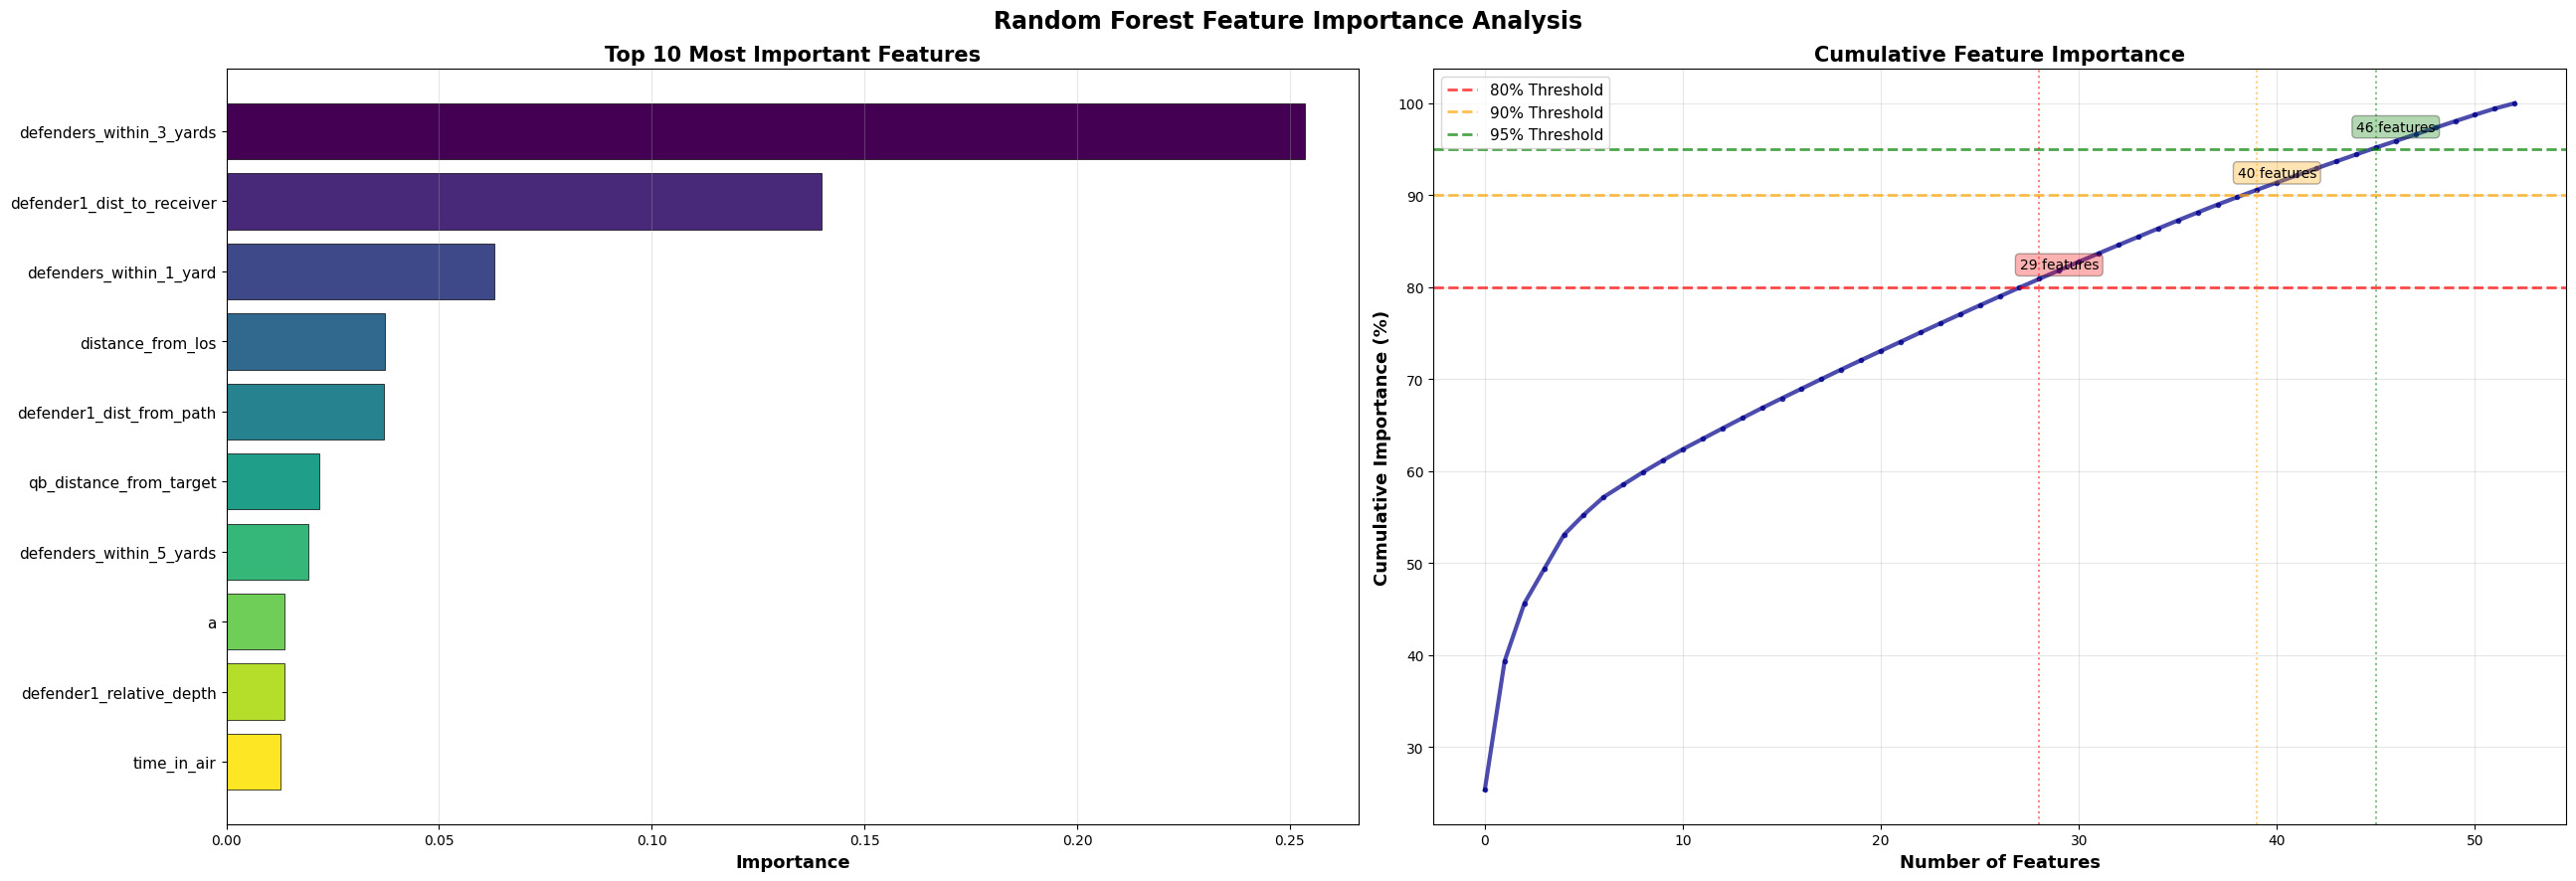


FEATURE IMPORTANCE SUMMARY

Total features: 53

Features needed to explain:
  • 80% of importance: 29 features
  • 90% of importance: 40 features
  • 95% of importance: 46 features

Top 10 Most Important Features:
                   Feature  Importance
  defenders_within_3_yards    0.253612
defender1_dist_to_receiver    0.139917
   defenders_within_1_yard    0.062885
         distance_from_los    0.037303
  defender1_dist_from_path    0.037139
   qb_distance_from_target    0.021762
  defenders_within_5_yards    0.019190
                         a    0.013681
  defender1_relative_depth    0.013603
               time_in_air    0.012680

Bottom 10 Least Important Features:
                        Feature  Importance
             lagged2_receiver_y    0.007543
       defender4_dist_from_path    0.007500
                     receiver_x    0.007495
num_defenders_within_2_yards_qb    0.007203
                     receiver_y    0.007187
  num_players_within_5_yards_qb    0.007180
       defe

In [25]:
#Create feature importance visualization
fig, axes = plt.subplots(1, 2, figsize=(26, 9)) 

#####################################################################
#Plot 1: Top 20 Features - Horizontal Bar Chart
#####################################################################

ax1 = axes[0]

top_n = 10
top_features = feat_imp.head(top_n)

#Create color gradient
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))

bars = ax1.barh(range(len(top_features)), top_features['Importance'], 
                color=colors, edgecolor='black', linewidth=0.5)

ax1.set_yticks(range(len(top_features)))
ax1.set_yticklabels(top_features['Feature'], fontsize=11)  #Slightly larger
ax1.set_xlabel('Importance', fontsize=13, fontweight='bold')
ax1.set_title(f'Top {top_n} Most Important Features', fontsize=15, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(alpha=0.3, axis='x')


#####################################################################
#Plot 2: Cumulative Importance
#####################################################################
ax2 = axes[1]

#Calculate cumulative importance
feature_importance_sorted = feat_imp.sort_values('Importance', ascending=False).copy()
feature_importance_sorted['cumulative_importance'] = feature_importance_sorted['Importance'].cumsum()

#Plot cumulative importance
ax2.plot(range(len(feature_importance_sorted)), 
         feature_importance_sorted['cumulative_importance'] * 100,
         linewidth=3, color='darkblue', marker='o', markersize=3, alpha=0.7)

#Add reference lines
ax2.axhline(80, color='red', linestyle='--', linewidth=2, alpha=0.7, label='80% Threshold')
ax2.axhline(90, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='90% Threshold')
ax2.axhline(95, color='green', linestyle='--', linewidth=2, alpha=0.7, label='95% Threshold')

#Find how many features needed for 80%, 90%, 95%
features_80 = (feature_importance_sorted['cumulative_importance'] >= 0.80).idxmax()
features_90 = (feature_importance_sorted['cumulative_importance'] >= 0.90).idxmax()
features_95 = (feature_importance_sorted['cumulative_importance'] >= 0.95).idxmax()

n_80 = feature_importance_sorted.index.get_loc(features_80) + 1
n_90 = feature_importance_sorted.index.get_loc(features_90) + 1
n_95 = feature_importance_sorted.index.get_loc(features_95) + 1

ax2.axvline(n_80 - 1, color='red', linestyle=':', linewidth=1.5, alpha=0.5)
ax2.axvline(n_90 - 1, color='orange', linestyle=':', linewidth=1.5, alpha=0.5)
ax2.axvline(n_95 - 1, color='green', linestyle=':', linewidth=1.5, alpha=0.5)

ax2.set_xlabel('Number of Features', fontsize=13, fontweight='bold')
ax2.set_ylabel('Cumulative Importance (%)', fontsize=13, fontweight='bold')
ax2.set_title('Cumulative Feature Importance', fontsize=15, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

#Add annotations
ax2.text(n_80, 82, f'{n_80} features', fontsize=10, ha='center', 
        bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.3))
ax2.text(n_90, 92, f'{n_90} features', fontsize=10, ha='center',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='orange', alpha=0.3))
ax2.text(n_95, 97, f'{n_95} features', fontsize=10, ha='center',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='green', alpha=0.3))

plt.suptitle('Random Forest Feature Importance Analysis', 
            fontsize=17, fontweight='bold', y=0.98)

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')  #Save figure
plt.show()

#Print summary statistics
print("\n" + "="*70)
print("FEATURE IMPORTANCE SUMMARY")
print("="*70)

print(f"\nTotal features: {len(feature_importance_sorted)}")
print(f"\nFeatures needed to explain:")
print(f"  • 80% of importance: {n_80} features")
print(f"  • 90% of importance: {n_90} features")
print(f"  • 95% of importance: {n_95} features")

print(f"\nTop 10 Most Important Features:")
print(feat_imp.head(10).to_string(index=False))

print(f"\nBottom 10 Least Important Features:")
print(feat_imp.tail(10).to_string(index=False))

Mean predicted probability: 0.6258
Actual completion rate:   0.6253


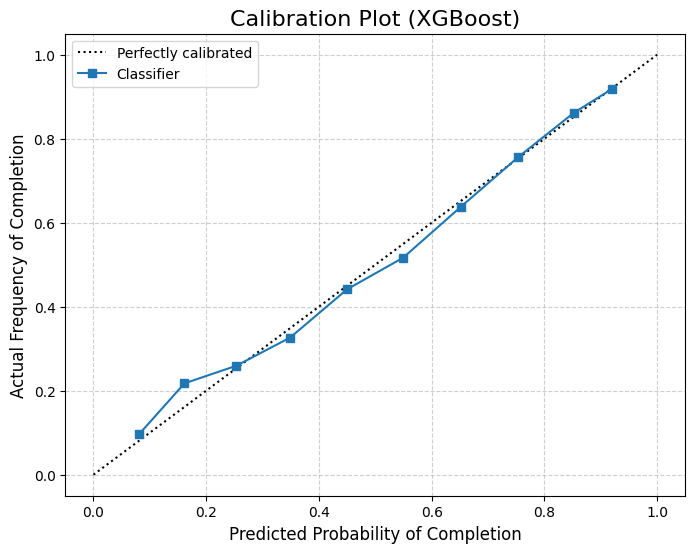

In [26]:
#Get probabilities for the complete passes
prob_complete = xgb_model.predict_proba(X_test)[:, 1]

print(f"Mean predicted probability: {prob_complete.mean():.4f}")
print(f"Actual completion rate:   {y_test.mean():.4f}")

#Generate calibration plot

#Create the figure
fig, ax = plt.subplots(figsize=(8, 6))

#Plot the "perfect" calibration line (a 45-degree dashed line)
ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

#Plot the model's calibration curve
display = CalibrationDisplay.from_predictions(
    y_test,
    prob_complete,
    n_bins=10,     
    strategy='uniform', 
    ax=ax
)

#Set titles and labels
ax.set_title("Calibration Plot (XGBoost)", fontsize=16)
ax.set_xlabel("Predicted Probability of Completion", fontsize=12)
ax.set_ylabel("Actual Frequency of Completion", fontsize=12)
ax.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Model Analysis

Overall, we are pretty content with the performance of the model.

In comparison to other published catch probability models, our AUC and Accuracy tend to be in the same ballpark. Having it frame-by-frame leads to more variance in probabilities throughout a play, contributing to lower performance. 

But our calibration plot aligns with the actual frequency of completion extremely well. This means that if our model says there's an 80% chance of completion, that actually happens 80% of the time.

The top features also align with what we'd expect with nearest defender(s) and distance information being among the most important features. We think we did a good job of building nearest defender information, knowing that the nearest defender would likely be the biggest indicator of passes being completed. We were able to analyze distance, depth, location, and ball path interference for each defender, which helped our model tremendously.

Let's apply our trained model to the entire season's worth of data.

In [27]:
#Generate predictions on entire dataset using existing trained model

print("=" * 70)
print("GENERATING PREDICTIONS ON ENTIRE DATASET")
print("=" * 70)

#Prepare the full dataset the same way as training data
X_full = final_cleaned_output.copy()

#Select features
X_full = X_full[feature_cols_cp]

print(f"Generating predictions for {len(X_full):,} frames...")

#Use the trained model to predict
y_pred_full = xgb_model.predict(X_full)
y_pred_proba_full = xgb_model.predict_proba(X_full)[:, 1]

#Add predictions to the dataframe
final_cleaned_output['predicted_catch_prob'] = y_pred_proba_full
final_cleaned_output['predicted_catch'] = y_pred_full

print(f"\n✓ Predictions added to final_cleaned_output")
print(f"  • Column 'predicted_catch_prob': Probability of catch")
print(f"  • Column 'predicted_catch': Binary prediction (0/1)")

#Create full dataset version for analysis
final_data = final_cleaned_output.copy()

print("\n✓ test_data_full created (entire dataset with predictions)")
print("=" * 70)

GENERATING PREDICTIONS ON ENTIRE DATASET
Generating predictions for 160,263 frames...

✓ Predictions added to final_cleaned_output
  • Column 'predicted_catch_prob': Probability of catch
  • Column 'predicted_catch': Binary prediction (0/1)

✓ test_data_full created (entire dataset with predictions)


# Expected Yards After Catch Model

The next step in getting enough information for the "Presence Rating" was an Expected Yards After Catch model (xYAC). 

We extracted the actual YAC by subtracting the pass length from the total yards gained on completions only.

### Algorithm Choice: XGBoost (Extreme Gradient Boosting)

We chose to utilize XGBoost for this classification task due to its ability to handle non-linear interactions between spatial features. It also excels at handling high-dimensional data and generally leads to high predictive accuracy.

In [28]:
final_cleaned_output["yards_after_catch"] = final_cleaned_output["pre_penalty_yards_gained"] - final_cleaned_output["pass_length"]

### Feature Selection

A majority of the features from the Completion Probability model will carry over to this model. The only features that will be removed will be the ones related to the QB.

We want to add the following features that give us more information on how many yards the receiver can gain after the catch.

Features:
* Orientation Penalty: Is the receiver facing the correct way to potentially gain more YAC?
* Sideline Danger: Based on the receiver's positioning, is he in danger of running out of bounds?
* Defenders Ahead: How many defenders are in front of the receiver at the catch point?
* Distance to End Zone: How far is the receiver from the end zone? This helps us gauge how many yards are realistically possible to be gained.
* Downfield Velocity: How fast is the receiver running downfield? We want the receiver to run downfield and not side-to-side.
* Defender Isolation: How many defenders does the receiver have to beat?
* Open Space: How much open space is there for the receiver to run through?

Build out YACOE specific feats

In [29]:
def get_orientation_penalty(row):
    
    #Calculate absolute difference from 0 (ideal facing)
    angle = row['o']
    diff = min(abs(angle - 0), abs(angle - 360))
    return diff

final_cleaned_output['orientation_penalty'] = final_cleaned_output.apply(get_orientation_penalty, axis=1)

In [30]:
#Create a binary or continuous penalty for running out of bounds

def get_sideline_danger(row):
    
    y = row['receiver_y']
    angle_rad = np.radians(90 - row['dir']) # Convert to math angle
    v_y = np.sin(angle_rad) # Vertical velocity component (towards sideline)

    
    #If receiver is close to top sideline (y > 45) AND moving up (v_y > 0)
    if y > 45 and v_y > 0:
        return 1
    #If receiver is close to bottom sideline (y < 8) AND moving down (v_y < 0)
    elif y < 8 and v_y < 0:
        return 1
    return 0

final_cleaned_output['sideline_danger'] = final_cleaned_output.apply(get_sideline_danger, axis=1)

In [31]:
def count_defenders_ahead(row):
    
    rx = row['receiver_x']
    count = 0
    
    #Loop through defenders
    for i in range(1, 6):
        d_x = row.get(f'defender{i}_x', -999) # Use get to avoid errors

        #If the defender is closer to the endzone than the receiver, count it
        if d_x > rx: 
            count += 1
    return count

final_cleaned_output['defenders_ahead'] = final_cleaned_output.apply(count_defenders_ahead, axis=1)

In [32]:
def calculate_dist_to_goal(row):
    
    #Check the play direction to assure which endzone we need to reach
    if row['play_direction'] == 'right':
        #Moving towards x=120. The goal line is at x=110.
        return 110 - row['receiver_x']
    else:
        #Moving towards x=0. The goal line is at x=10.
        return row['receiver_x'] - 10

final_cleaned_output['receiver_dist_to_goal'] = final_cleaned_output.apply(calculate_dist_to_goal, axis=1)

In [33]:
def calculate_downfield_velocity(row):
    
    #Convert direction to radians
    theta_rad = np.radians(90 - row['dir'])
    
    #Calculate velocity in the x
    #Positive = Moving towards x=100 (or 110)
    #Negative = Moving towards x=0
    v_x = row['s'] * np.cos(theta_rad)
    
    #If play is going Right (to 110), positive v_x is good.
    #If play is going Left (to 0), negative v_x is good.
    if row['play_direction'] == 'left':
        return -v_x
    else:
        return v_x

final_cleaned_output['downfield_velocity'] = final_cleaned_output.apply(calculate_downfield_velocity, axis=1)

In [34]:
#Measure how isolated the nearest defender is from the next closest defender
final_cleaned_output['defender_isolation_gap'] = (
    final_cleaned_output['defender2_dist_to_receiver'] - final_cleaned_output['defender1_dist_to_receiver']
)

In [35]:
def calculate_open_space_cone(row):
    
    #Create an estimated cone of space
    #Cone is 170 degrees total (-85 to +85)
    #Break it into 10 degree sections
    angles_to_check = np.arange(-85, 86, 10) 

    rx, ry = row['receiver_x'], row['receiver_y']
    
    #Get receiver direction in radians
    if pd.isna(row['dir']):
        return 0
    r_dir_math = np.radians(90 - row['dir'])
   
    #Adjust based on the direction of the play
    #If play is Left-to-Right (X increases), LOS is likely behind (Negative X relative to Rec)
    #If play is Right-to-Left (X decreases), LOS is behind (Positive X relative to Rec)
    going_right = row['play_direction'] == 'right'
    los_x = row['absolute_yardline_number']
    if not going_right:
        los_x = 100 - los_x 
    
    valid_rays_total_dist = 0
    valid_ray_count = 0
    
    #Cast the rays
    for angle_offset in angles_to_check:
        
        #Calculate the absolute angle of this specific ray
        ray_angle = r_dir_math + np.radians(angle_offset)
        
        #Unit vector for this ray
        u_x = np.cos(ray_angle)
        u_y = np.sin(ray_angle)
        
        #If going right (positive X), a "backward" path has negative u_x
        if going_right and u_x < -0.1: continue
        if not going_right and u_x > 0.1: continue
        
        #We assume a max vision of 30 yards to save computation
        max_dist = 30.0 
    
        #Distance to top sideline (53.3)
        if u_y > 0: #Moving Up
            dist_sideline = (53.3 - ry) / u_y
            max_dist = min(max_dist, dist_sideline)
        elif u_y < 0: #Moving Down
            dist_sideline = (0 - ry) / u_y
            max_dist = min(max_dist, dist_sideline)
            
        #Check if the closest defender on this specific ray path
        closest_def_dist = max_dist 
        
        #Loop through all defenders
        for i in range(1, 6):
            
            dx = row[f'defender{i}_x']
            dy = row[f'defender{i}_y']
                
            #Vector to defender
            vec_x = dx - rx
            vec_y = dy - ry
            dist_to_def = np.sqrt(vec_x**2 + vec_y**2)
            
            #Project defender onto the ray
            #Dot product to find distance along the ray
            dot_prod = (vec_x * u_x) + (vec_y * u_y)
            
            #Rejection: How far "off" the ray is the defender?
            if dot_prod > 0: # Defender is in front
                rejection_sq = dist_to_def**2 - dot_prod**2
                
                #If the defender is within 1.5 yards of the ray line, they block it
                if rejection_sq < (1.5**2):
                    closest_def_dist = min(closest_def_dist, dot_prod)

        #Add the valid distance of this ray to the total
        valid_rays_total_dist += closest_def_dist
        valid_ray_count += 1
        
    #Aggregate
    if valid_ray_count == 0:
        return 0
    
    #Returns average "open yards" available in the cone
    return valid_rays_total_dist / valid_ray_count

final_cleaned_output['cone_open_space'] = final_cleaned_output.apply(calculate_open_space_cone, axis=1)

### Model

Now that we have built the necessary features for the xYAC model, let's train it.

We are also going to make the following feature changes.

Removed Features:
* Initial Receiver X/Y
* Lagged Receiver X/Y
* Number of Defenders in Ball Path
* Defender(s) Distance from Ball Path

In [36]:
#Subsetting the data to only include completions and removing fumbles, because they mess with the net yards
final_completed = final_cleaned_output[final_cleaned_output["pass_result"] == "C"]
final_completed = final_completed[~final_completed["play_description"].str.contains("FUMBLES", case=False, na=False)]

#Define feature set
numeric_features2 = [
    
    #Context
    'absolute_yardline_number', 'distance_from_los', 'distance_from_sideline', 'time_in_air',
    'yards_to_go', 'defenders_in_the_box', 'dropback_distance',
    
    #Receiver Info
    'receiver_x', 'receiver_y','s', 'a', 'dir', 'o',
    
    #Defender Structure
    'num_defenders_behind', 'num_defenders_in_front', 
    'defenders_within_1_yard', 'defenders_within_3_yards', 'defenders_within_5_yards',

    #YACOE Specific
    'defenders_ahead', 'sideline_danger', 'orientation_penalty', 'receiver_dist_to_goal', 'downfield_velocity',
    'defender_isolation_gap', 'cone_open_space'
    
]

#Defender Information
for i in range(1, 6):
    numeric_features2.extend([
        f'defender{i}_dist_to_receiver',
        f'defender{i}_relative_depth',
        f'defender{i}_horizontal_leverage',
    ])


X = final_completed.copy()

feature_cols_yac = numeric_features2 
X = X[feature_cols_yac]
y = final_completed["yards_after_catch"]

#Handling missing values
print(f"\nMissing values before imputation:")
missing_counts = X.isna().sum()
print(missing_counts[missing_counts > 0])

for col in X.columns:
    if X[col].isna().any():
        X[col].fillna(X[col].median(), inplace=True)

#Train/test split and stratify by plays rather than by frames (split plays first)
plays = final_completed[['game_id', 'play_id']].drop_duplicates()

#Use 80/20 train and test split
train_plays, test_plays = train_test_split(
    plays,
    test_size=0.2,
    random_state=42,
)

#Now we create train and test dataframes based on the plays
#Get original row indices for train plays
train_idx = (
    final_completed
    .reset_index()  
    .merge(train_plays, on=['game_id', 'play_id'], how='inner')['index']
)

#Same for test
test_idx = (
    final_completed
    .reset_index()
    .merge(test_plays, on=['game_id', 'play_id'], how='inner')['index']
)

#Now safely index X and y
X_train, X_test = X.loc[train_idx], X.loc[test_idx]
y_train, y_test = y.loc[train_idx], y.loc[test_idx]


Missing values before imputation:
Series([], dtype: int64)


In [37]:
print("Training XGBoost Regressor...")

xgb_model_yac = XGBRegressor(
    n_estimators=1000,       
    learning_rate=0.025,      
    max_depth=4,             
    min_child_weight=20,    
    subsample=0.7,           
    colsample_bytree=0.7,    
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=50
)

#Fit the model
xgb_model_yac.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=100
)

#Make predictions
y_pred = xgb_model_yac.predict(X_test)

#Evaluation Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"\nRMSE: {rmse:.4f} (Average error in yards)")
print(f"R2 Score: {r2:.4f}")

feature_importance = pd.DataFrame({
    'feature': feature_cols_yac,
    'importance': xgb_model_yac.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.to_string(index=False))

#Add predictions back to test data for analysis
test_data_yac = final_cleaned_output.loc[test_idx].copy()
test_data_yac['predicted_yac'] = y_pred
test_data_yac['yac_error'] = test_data_yac['yards_after_catch'] - test_data_yac['predicted_yac']

test_data_yac.head()

Training XGBoost Regressor...
[0]	validation_0-rmse:6.75688
[100]	validation_0-rmse:5.99966
[200]	validation_0-rmse:5.91098
[300]	validation_0-rmse:5.88663
[400]	validation_0-rmse:5.87979
[500]	validation_0-rmse:5.87693
[564]	validation_0-rmse:5.87951

RMSE: 5.8747 (Average error in yards)
R2 Score: 0.2486
                      feature  importance
     defenders_within_5_yards    0.124754
         num_defenders_behind    0.082657
              cone_open_space    0.057701
   defender1_dist_to_receiver    0.051810
              sideline_danger    0.051343
        receiver_dist_to_goal    0.034511
     defender1_relative_depth    0.029491
   defender2_dist_to_receiver    0.024824
                            s    0.024432
       defender_isolation_gap    0.024085
     defender2_relative_depth    0.022224
           downfield_velocity    0.022211
                            a    0.022030
     absolute_yardline_number    0.021348
       distance_from_sideline    0.020405
     defender5_relat

,game_id,play_id,nfl_id,frame_id,x,y,nfl_id_target,receiver_x,receiver_y,dist_to_receiver,defender1_dist_to_receiver,defender2_dist_to_receiver,defender3_dist_to_receiver,defender4_dist_to_receiver,defender5_dist_to_receiver,defender1_nfl_id,defender2_nfl_id,defender3_nfl_id,defender4_nfl_id,defender5_nfl_id,defender1_x,defender2_x,defender3_x,defender4_x,defender5_x,defender1_y,defender2_y,defender3_y,defender4_y,defender5_y,defenders_within_1_yard,defenders_within_3_yards,defenders_within_5_yards,play_direction,absolute_yardline_number,player_name,player_position,x_meta,y_meta,s,a,dir,o,ball_land_x,ball_land_y,qb_release_x,qb_release_y,qb_release_a,qb_release_s,qb_release_dir,qb_release_o,qb_distance_from_sideline,num_defenders_within_2_yards_qb,num_defenders_within_5_yards_qb,num_players_within_5_yards_qb,defender1_relative_depth,defender1_dist_from_path,defender2_relative_depth,defender2_dist_from_path,defender3_relative_depth,defender3_dist_from_path,defender4_relative_depth,defender4_dist_from_path,defender5_relative_depth,defender5_dist_from_path,num_defenders_in_front,num_defenders_behind,num_defenders_in_passing_lane,defender1_horizontal_leverage,defender2_horizontal_leverage,defender3_horizontal_leverage,defender4_horizontal_leverage,defender5_horizontal_leverage,time_in_air,distance_from_sideline,distance_from_los,qb_distance_from_target,initial_receiver_x,initial_receiver_y,lagged_receiver_x,lagged_receiver_y,lagged2_receiver_x,lagged2_receiver_y,quarter,down,yards_to_go,offense_formation,receiver_alignment,play_action,dropback_distance,defenders_in_the_box,team_coverage_man_zone,team_coverage_type,pass_result,expected_points_added,play_description,pre_penalty_yards_gained,pass_length,is_complete,predicted_catch_prob,predicted_catch,yards_after_catch,orientation_penalty,sideline_danger,defenders_ahead,receiver_dist_to_goal,downfield_velocity,defender_isolation_gap,cone_open_space,predicted_yac,yac_error
21,2023090700,194,41325,1,88.43,21.99,41325,88.43,21.99,0.0,1.935459,9.398649,12.305743,12.703204,99.0,54653.0,44888.0,53953.0,55910.0,-1.0,90.31,85.38,76.70,77.26,-999.0,22.45,30.88,18.27,28.04,-999.0,0.0,1.0,1.0,left,89,Jerick McKinnon,RB,88.98,22.23,6.09,2.14,245.74,314.63,84.940002,21.75,97.62,29.67,1.64,0.96,185.14,285.7,23.63,0.0,0.0,0.0,-1.737558,0.852581,-3.360366,8.777388,11.386246,4.667409,4.691514,11.805130,99.0,99.0,2,2,1,-0.852581,8.777388,4.667409,11.805130,99.0,0.0,21.99,0.57,11.976581,88.43,21.99,88.43,21.99,88.43,21.99,1,3,2,SHOTGUN,2x2,False,3.86,6,MAN_COVERAGE,COVER_1_MAN,C,1.702563,(12:56) (Shotgun) P.Mahomes pass short left to J.McKinnon to KC 31 for 10 yards (M.Rodriguez).,10,6,1,0.744303,1,4,45.37,0,1,78.43,5.552194,7.463190,26.093051,11.993370,-7.993370
22,2023090700,194,41325,2,87.88,21.76,41325,87.88,21.76,0.0,1.953510,9.075423,12.001671,12.834532,99.0,54653.0,44888.0,53953.0,55910.0,-1.0,89.79,85.40,76.37,77.02,-999.0,22.17,30.49,18.36,28.60,-999.0,0.0,1.0,1.0,left,89,Jerick McKinnon,RB,88.98,22.23,6.09,2.14,245.74,314.63,84.940002,21.75,97.62,29.67,1.64,0.96,185.14,285.7,23.63,0.0,0.0,0.0,-1.741126,0.885821,-3.578376,8.340175,11.078158,4.616764,4.118164,12.155901,99.0,99.0,2,2,1,-0.885821,8.340175,4.616764,12.155901,99.0,0.1,21.76,1.12,12.547338,88.43,21.99,88.43,21.99,88.43,21.99,1,3,2,SHOTGUN,2x2,False,3.86,6,MAN_COVERAGE,COVER_1_MAN,C,1.702563,(12:56) (Shotgun) P.Mahomes pass short left to J.McKinnon to KC 31 for 10 yards (M.Rodriguez).,10,6,1,0.720102,1,4,45.37,0,1,77.88,5.552194,7.121913,26.001983,12.018606,-8.018606
23,2023090700,194,41325,3,87.33,21.56,41325,87.33,21.56,0.0,1.933805,8.706607,11.655355,12.972220,99.0,54653.0,44888.0,53953.0,55910.0,-1.0,89.23,85.40,76.10,76.81,-999.0,21.92,30.05,18.44,29.15,-999.0,0.0,1.0,1.0,left,89,Jerick McKinnon,RB,88.98,22.23,6.09,2.14,245.74,314.63,84.940002,21.75,97.62,29.67,1.64,0.96,185.14,285.7,23.63,0.0,0.0,0.0,-1.715082,0.893361,-3.739512,7.862636,10.751217,4.500959,3.564093,12.473001,99.0,99.0,2,2,1,-0.893361,7.862636,4.500959,12.473001

Let's calculate the residual error between actual and predicted YAC and analyze the predictions.

Plotting the residuals will give us an indication of model behavior.

In [38]:
test_data_yac["residual"] = test_data_yac["yards_after_catch"] - test_data_yac["predicted_yac"]
test_data_yac["predicted_yac"].describe()

count    19813.000000
mean         4.548009
std          3.172398
min         -1.613481
25%          2.171094
50%          3.858259
75%          6.552734
max         24.033136
Name: predicted_yac, dtype: float64

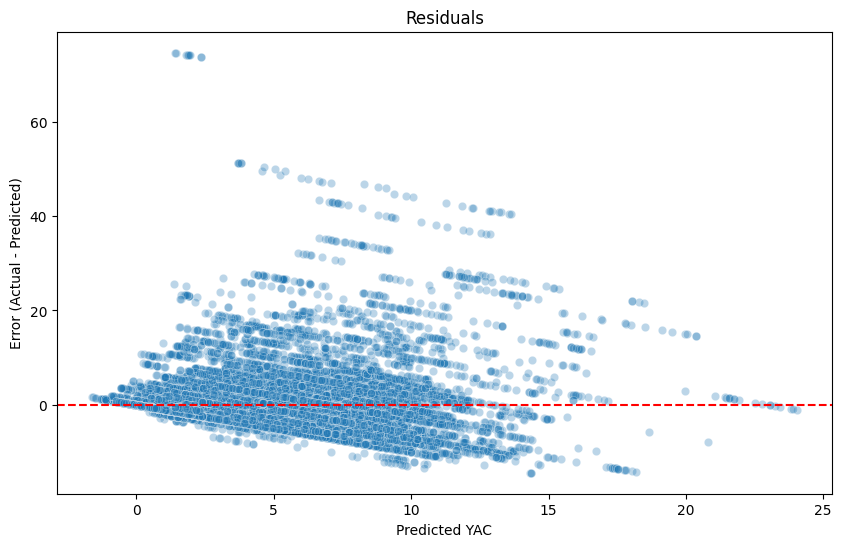

In [39]:
#Calculate residuals
test_data_yac = final_completed.loc[test_idx].copy()
test_data_yac['predicted_yac'] = xgb_model_yac.predict(X_test)
test_data_yac['residual'] = test_data_yac['yards_after_catch'] - test_data_yac['predicted_yac']

#Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='predicted_yac', y='residual', data=test_data_yac, alpha=0.3)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted YAC')
plt.ylabel('Error (Actual - Predicted)')
plt.title('Residuals')
plt.show()

Overall, we are pretty happy with the results of this model.

According to RMSE, we are on average about 6 yards off of the actual YAC, which makes sense if you factor in the potential variance of a prediction like this. There is a lot of randomness when it comes to making plays once the ball is caught by the receiver and long-distance plays are likely estimated with low xYAC.

# Applications

Now that we have both models, we can begin working towards the Presence Rating.

Expand xYAC predictions to the entire dataset

In [40]:
#Convert to category data type
final_cleaned_output["team_coverage_man_zone"] = final_cleaned_output["team_coverage_man_zone"].astype("category")
final_cleaned_output["team_coverage_type"] = final_cleaned_output["team_coverage_type"].astype("category")

#Predict over the entire dataset
X_full = final_cleaned_output[feature_cols_yac]
final_cleaned_output["predicted_yac"] = xgb_model_yac.predict(X_full)

#Set incompletions to 0
final_cleaned_output["yards_after_catch"] = np.where(final_cleaned_output["pass_result"] != "C", 0, final_cleaned_output["yards_after_catch"])

#Predict again with incompletions factored in
preds = xgb_model_yac.predict(X_full)

print("Prediction summary:")
print(pd.Series(preds).describe())

#No NaNs or infs
assert not np.isnan(preds).any()
assert np.isfinite(preds).all()


Prediction summary:
count    160263.000000
mean          4.158305
std           3.240957
min          -3.911133
25%           1.844134
50%           3.448039
75%           5.922885
max          39.334236
dtype: float64


### Calculate the "Value Score"

The value score assigns an expected value for throwing the pass to the receiver at each frame by multiplying the completion probability by the expected number of yards gained (air yards + xYAC).

Value Score = completion probability(air yards + expected YAC)

In [41]:
final_cleaned_output["value_score"] = final_cleaned_output["predicted_catch_prob"]*(final_cleaned_output["pass_length"]+final_cleaned_output["predicted_yac"])

## Presence Rating

Now that we have the value score, we can begin the counterfactual analysis.

This allows us to determine a defender's **Presence Rating**. With this we can answer the question of "What would the Catch Probability and Expected YAC have been if Defender X was simply not there?"

In [42]:
GAME_ID = 2023100803   # <-- fill in
PLAY_ID = 3855   # <-- fill in

#Number of defenders
slots = range(1, 6) 

#Get the catch probability and xYAC for a set of rows
def score_cp_yac(df_rows):

    #Predict catch prob
    X_cp = df_rows[feature_cols_cp]
    p = xgb_model.predict_proba(X_cp)[:, 1]

    #Predict xYAC
    X_yac = df_rows[feature_cols_yac]
    yac = xgb_model_yac.predict(X_yac)
    
    return p, yac

#Get all feature columns associated with nearest defenders
def defender_slot_cols(df, k):
    prefix = f"defender{k}_"
    cols = [c for c in df.columns if c.lower().startswith(prefix)]
    return [c for c in cols if c.lower() != f"defender{k}_nfl_id"]

#Remove chosen defender from the play
def remove_defender_k(df_rows, k):
    out = df_rows.copy()
    k_cols = defender_slot_cols(out, k)
    if k_cols:
        out.loc[:, k_cols] = 99
    return out


### Frame-by-frame Counterfactual Analysis

We can calculate the "What if" scenarios for CP and xYAC by systematically removing each defender.

In [43]:
#Get the selected play
play_df = final_cleaned_output.query("game_id == @GAME_ID and play_id == @PLAY_ID").copy()

#Sort by frame
if "frame_id" in play_df.columns:
    play_df = play_df.sort_values("frame_id").reset_index(drop=True)
else:
    play_df = play_df.reset_index(drop=True)

#View play and number of frames
print("Frames in play:", len(play_df))
play_df.head()

#Extract static features
pass_length = play_df["pass_length"].iloc[0] if len(play_df) > 0 else np.nan

results = []

#Run models on unchanged data
p_base, yac_base = score_cp_yac(play_df)

for idx in range(len(play_df)):

    #Grab single row of data for current frame
    frame_row = play_df.iloc[[idx]]
    frame_id = frame_row["frame_id"].iloc[0] if "frame_id" in frame_row.columns else idx

    #Save real predictions for comparison
    results.append({
        "game_id": GAME_ID,
        "play_id": PLAY_ID,
        "frame_id": frame_id,
        "pass_length": pass_length,
        "scenario": "baseline",
        "defender_slot": np.nan,
        "defender_nfl_id": np.nan,
        "p_catch": float(p_base[idx]),
        "pred_yac": float(yac_base[idx])
    })

    #Iterate through defenders
    for k in slots:

        #ID the defender
        id_col = f"defender{k}_nfl_id"
        if id_col not in frame_row.columns:
            continue

        #Make sure there is a defender in this slot
        defender_id = frame_row[id_col].iloc[0]
        if defender_id == -1:
            break
        if pd.isna(defender_id):
            continue

        #Remove defender k
        cf = remove_defender_k(frame_row, k)

        #Redo predictions and store
        p_cf, yac_cf = score_cp_yac(cf)

        #Append hypothetical results
        results.append({
            "game_id": GAME_ID,
            "play_id": PLAY_ID,
            "frame_id": frame_id,
            "pass_length": pass_length,
            "scenario": f"remove_defender{k}",
            "defender_slot": k,
            "defender_nfl_id": defender_id,
            "p_catch": float(p_cf[0]),
            "pred_yac": float(yac_cf[0])
        })


res_play = pd.DataFrame(results)
res_play.head(20)

Frames in play: 17


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,game_id,play_id,frame_id,pass_length,scenario,defender_slot,defender_nfl_id,p_catch,pred_yac
0,2023100803,3855,1,18,baseline,NaN,NaN,0.327141,4.751080
1,2023100803,3855,1,18,remove_defender1,1.0,55909.0,0.532857,5.338381
2,2023100803,3855,1,18,remove_defender2,2.0,52493.0,0.327141,4.751080
3,2023100803,3855,1,18,remove_defender3,3.0,47947.0,0.372694,4.689100
4,2023100803,3855,2,18,baseline,NaN,NaN,0.360172,4.411479
5,2023100803,3855,2,18,remove_defender1,1.0,55909.0,0.537825,5.036479
6,2023100803,3855,2,18,remove_defender2,2.0,52493.0,0.355582,4.411479
7,2023100803,3855,2,18,remove_defender3,3.0,47947.0,0.407538,4.349500
8,2023100803,3855,3,18,baseline,NaN,NaN,0.345612,4.065018
9,2023100803,3855,3,18,remove_defender1,1.0,55909.0,0.453989,4.910956


Let's calculate the defender impact by merging the baseline predictions back into the original dataset to find the delta (difference the defender made on the outcome)

In [44]:
#Filter for the actual rows
baseline = (
    res_play[res_play["scenario"] == "baseline"]
    .loc[:, ["frame_id", "p_catch", "pred_yac"]]
    .rename(columns={"p_catch": "p_base", "pred_yac": "yac_base"})
)

#Attach the baseline score to each row
#The hypothetical row now also knows the real score for each frame
res_play = res_play.merge(baseline, on="frame_id", how="left")
res_play["delta_p_catch"] = res_play["p_catch"] - res_play["p_base"]
res_play["delta_yac"] = res_play["pred_yac"] - res_play["yac_base"]

#Show only counterfactual rows
res_play[res_play["scenario"] != "baseline"].head(20)

,game_id,play_id,frame_id,pass_length,scenario,defender_slot,defender_nfl_id,p_catch,pred_yac,p_base,yac_base,delta_p_catch,delta_yac
1,2023100803,3855,1,18,remove_defender1,1.0,55909.0,0.532857,5.338381,0.327141,4.751080,0.205715,0.587302
2,2023100803,3855,1,18,remove_defender2,2.0,52493.0,0.327141,4.751080,0.327141,4.751080,0.000000,0.000000
3,2023100803,3855,1,18,remove_defender3,3.0,47947.0,0.372694,4.689100,0.327141,4.751080,0.045553,-0.061980
5,2023100803,3855,2,18,remove_defender1,1.0,55909.0,0.537825,5.036479,0.360172,4.411479,0.177653,0.625000
6,2023100803,3855,2,18,remove_defender2,2.0,52493.0,0.355582,4.411479,0.360172,4.411479,-0.004590,0.000000
7,2023100803,3855,2,18,remove_defender3,3.0,47947.0,0.407538,4.349500,0.360172,4.411479,0.047367,-0.061980
9,2023100803,3855,3,18,remove_defender1,1.0,55909.0,0.453989,4.910956,0.345612,4.065018,0.108376,0.845938
10,2023100803,3855,3,18,remove_defender2,2.0,52493.0,0.341109,4.065018,0.345612,4.065018,-0.004503,0.000000
11,2023100803,3855,3,18,remove_defender3,3.0,47947.0,0.392238,4.003038,0.345612,4.065018,0.046626,-0.061980
13,2023100803,3855,4,18,remove_defender1,1.0,55909.0,0.446983,4.721199,0.362210,3.827193,0.084773,0.894006


We can now calculate how much the value score changed (player impact).

If the value is positive, the defender was playing good defense. 
If the value was negative, the defender didn't have an impact.

In [45]:
res_play["value_change"] = res_play["p_catch"]*(res_play["pass_length"]+res_play["pred_yac"])-res_play["p_base"]*(res_play["yac_base"]+res_play["pass_length"])
res_play[res_play["scenario"] != "baseline"].head()


,game_id,play_id,frame_id,pass_length,scenario,defender_slot,defender_nfl_id,p_catch,pred_yac,p_base,yac_base,delta_p_catch,delta_yac,value_change
1,2023100803,3855,1,18,remove_defender1,1.0,55909.0,0.532857,5.338381,0.327141,4.751080,0.205715,0.587302,4.993191
2,2023100803,3855,1,18,remove_defender2,2.0,52493.0,0.327141,4.751080,0.327141,4.751080,0.000000,0.000000,0.000000
3,2023100803,3855,1,18,remove_defender3,3.0,47947.0,0.372694,4.689100,0.327141,4.751080,0.045553,-0.061980,1.013282
5,2023100803,3855,2,18,remove_defender1,1.0,55909.0,0.537825,5.036479,0.360172,4.411479,0.177653,0.625000,4.317606
6,2023100803,3855,2,18,remove_defender2,2.0,52493.0,0.355582,4.411479,0.360172,4.411479,-0.004590,0.000000,-0.102860


Let's do this for the entire dataset now.

In [46]:

def process_one_play(play_df, game_id, play_id, slots=range(1, 6)):
    
    #Sort frames
    if "frame_id" in play_df.columns:
        play_df = play_df.sort_values("frame_id").reset_index(drop=True)
        frame_ids = play_df["frame_id"].values
    else:
        play_df = play_df.reset_index(drop=True)
        frame_ids = np.arange(len(play_df))

    #Keep constant variables constant
    pass_length = play_df["pass_length"].iloc[0] if len(play_df) else np.nan

    #Baseline score
    p_base, yac_base = score_cp_yac(play_df)

    out_rows = []

    #Store actual results
    out_rows.append(pd.DataFrame({
        "game_id": game_id,
        "play_id": play_id,
        "frame_id": frame_ids,
        "pass_length": pass_length,
        "scenario": "baseline",
        "defender_slot": np.nan,
        "defender_nfl_id": np.nan,
        "p_catch": p_base.astype(float),
        "pred_yac": yac_base.astype(float),
    }))

    #Loop through defenders
    for k in slots:

        #Make sure they exist
        id_col = f"defender{k}_nfl_id"
        if id_col not in play_df.columns:
            continue

        defender_ids = play_df[id_col].values

        #Skip over missing values
        valid = (~pd.isna(defender_ids)) & (defender_ids != -1)
        if not np.any(valid):
            continue

        #Recalculate with defender removed
        cf_df = remove_defender_k(play_df, k)
        p_cf, yac_cf = score_cp_yac(cf_df)

        #Store new results
        tmp = pd.DataFrame({
            "game_id": game_id,
            "play_id": play_id,
            "frame_id": frame_ids,
            "pass_length": pass_length,
            "scenario": f"remove_defender{k}",
            "defender_slot": k,
            "defender_nfl_id": defender_ids,
            "p_catch": p_cf.astype(float),
            "pred_yac": yac_cf.astype(float),
        })

        #Only keep frames where the defender exists
        out_rows.append(tmp.loc[valid].reset_index(drop=True))

    res_play = pd.concat(out_rows, ignore_index=True)

    #Merge the baseline and new results and calculate the change in value scores
    baseline = (
        res_play[res_play["scenario"] == "baseline"]
        .loc[:, ["frame_id", "p_catch", "pred_yac"]]
        .rename(columns={"p_catch": "p_base", "pred_yac": "yac_base"})
    )

    res_play = res_play.merge(baseline, on="frame_id", how="left")
    res_play["delta_p_catch"] = res_play["p_catch"] - res_play["p_base"]
    res_play["delta_yac"] = res_play["pred_yac"] - res_play["yac_base"]

    return res_play



#Run over the whole dataset
all_results = []

for gid, game_df in final_cleaned_output.groupby("game_id", sort=False):
    plays = list(game_df.groupby("play_id", sort=False))

    for pid, gdf in plays:
        if len(gdf) == 0:
            continue
        all_results.append(process_one_play(gdf.copy(), gid, pid, slots=slots))

    print(f"Finished game_id={gid} ({len(plays)} plays)")

res_all = pd.concat(all_results, ignore_index=True)
res_all_cf = res_all[res_all["scenario"] != "baseline"].reset_index(drop=True)

Finished game_id=2023090700 (58 plays)
Finished game_id=2023091000 (37 plays)
Finished game_id=2023091001 (44 plays)
Finished game_id=2023091002 (45 plays)
Finished game_id=2023091003 (56 plays)
Finished game_id=2023091004 (64 plays)
Finished game_id=2023091005 (47 plays)
Finished game_id=2023091006 (60 plays)
Finished game_id=2023091007 (43 plays)
Finished game_id=2023091008 (52 plays)
Finished game_id=2023091009 (50 plays)
Finished game_id=2023091010 (60 plays)
Finished game_id=2023091011 (64 plays)
Finished game_id=2023091012 (50 plays)
Finished game_id=2023091013 (42 plays)
Finished game_id=2023091100 (45 plays)
Finished game_id=2023091400 (55 plays)
Finished game_id=2023091700 (43 plays)
Finished game_id=2023091701 (48 plays)
Finished game_id=2023091702 (53 plays)
Finished game_id=2023091703 (60 plays)
Finished game_id=2023091704 (58 plays)
Finished game_id=2023091705 (58 plays)
Finished game_id=2023091706 (46 plays)
Finished game_id=2023091707 (51 plays)
Finished game_id=20230917

Analyze the counterfactual rows and calculate the value change

In [47]:
#Only counterfactual rows
res_all_cf = res_all_cf[res_all_cf["scenario"] != "baseline"].copy()

#Value change
res_all_cf["value_change"] = (
    res_all_cf["p_catch"] * (res_all_cf["pass_length"] + res_all_cf["pred_yac"])
    - res_all_cf["p_base"] * (res_all_cf["pass_length"] + res_all_cf["yac_base"])
)

#Order by defender nfl_id, then play, then frame 
res_all_cf = res_all_cf.sort_values(
    ["game_id", "play_id", "frame_id"]
).reset_index(drop=True)

res_all_cf

,game_id,play_id,frame_id,pass_length,scenario,defender_slot,defender_nfl_id,p_catch,pred_yac,p_base,yac_base,delta_p_catch,delta_yac,value_change
0,2023090700,101,1,22,remove_defender1,1.0,46137.0,0.645527,11.821451,0.482194,4.543148,0.163333,7.278303,9.033718
1,2023090700,101,1,22,remove_defender2,2.0,52546.0,0.532708,5.134325,0.482194,4.543148,0.050514,0.591177,1.655733
2,2023090700,101,2,22,remove_defender1,1.0,46137.0,0.685962,12.697384,0.486988,6.000351,0.198973,6.697032,10.165231
3,2023090700,101,2,22,remove_defender2,2.0,52546.0,0.508230,6.577590,0.486988,6.000351,0.021242,0.577239,0.888154
4,2023090700,101,3,22,remove_defender1,1.0,46137.0,0.699479,12.481216,0.488135,5.784185,0.211344,6.697031,10.556445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398802,2024010713,4018,17,18,remove_defender2,2.0,47844.0,0.264607,4.152193,0.201893,2.875212,0.062713,1.276980,1.647054
398803,2024010713,4018,17,18,remove_defender3,3.0,52647.0,0.170477,2.960146,0.201893,2.875212,-0.031416,0.084934,-0.641333
398804,2024010713,4018,18,18,remove_defender1,1.0,46190.0,0.427130,9.202798,0.197289,2.483839,0.229841,6.718959,7.577897
398805,2024010713,4018,18,18,remove_defender2,2.0,47844.0,0.259631,3.601597,0.197289,2.483839,0.062342,1.117758,1.567201


Calculate the **Presence Rating**, Overall Catch Probability Change, and Overall Expected YAC Change

Group by game id, play id, defender id, arrange by frame, and get the first and last frames for each defender on each play.

In [48]:
summary_cf = (
    res_all_cf
    .dropna(subset=["defender_nfl_id"])
    .loc[res_all_cf["defender_nfl_id"] != -1]
    .sort_values(["game_id", "play_id", "defender_nfl_id", "frame_id"])
    .groupby(["game_id", "play_id", "defender_nfl_id"], as_index=False)
    .agg(
        first_frame=("frame_id", "first"),
        last_frame=("frame_id", "last"),

        first_delta_p_catch=("delta_p_catch", "first"),
        first_delta_yac=("delta_yac", "first"),
        first_value_change=("value_change", "first"),

        last_delta_p_catch=("delta_p_catch", "last"),
        last_delta_yac=("delta_yac", "last"),
        last_value_change=("value_change", "last"),

        n_frames=("frame_id", "count"),
    )
)

summary_cf["presence_score"] = summary_cf["last_value_change"]-summary_cf["first_value_change"]
summary_cf["overall_catch_prob_change"] = summary_cf["last_delta_p_catch"]-summary_cf["first_delta_p_catch"]
summary_cf["overall_exp_yac_change"] = summary_cf["last_delta_yac"]-summary_cf["first_delta_yac"]

summary_cf.head(20)

,game_id,play_id,defender_nfl_id,first_frame,last_frame,first_delta_p_catch,first_delta_yac,first_value_change,last_delta_p_catch,last_delta_yac,last_value_change,n_frames,presence_score,overall_catch_prob_change,overall_exp_yac_change
0,2023090700,101,46137.0,1,21,0.163333,7.278303,9.033718,0.233225,6.483028,10.302240,21,1.268522,0.069892,-0.795275
1,2023090700,101,52546.0,1,21,0.050514,0.591177,1.655733,-0.031855,1.284173,-0.395742,21,-2.051476,-0.082370,0.692997
2,2023090700,194,44888.0,1,9,-0.033701,1.239789,0.274608,0.000613,2.370434,1.022367,9,0.747758,0.034314,1.130645
3,2023090700,194,53953.0,1,9,0.004580,0.046460,0.117201,-0.001992,0.337607,0.116897,9,-0.000305,-0.006572,0.291147
4,2023090700,194,54653.0,1,9,0.152719,-3.242242,-0.160431,0.450028,1.973636,7.755851,9,7.916282,0.297309,5.215878
5,2023090700,194,55910.0,1,9,0.007190,0.243682,0.312491,0.013456,0.046706,0.200718,9,-0.111772,0.006267,-0.196976
6,2023090700,219,44888.0,1,8,-0.000370,0.586429,0.510562,0.010075,0.569022,0.539887,8,0.029326,0.010445,-0.017407
7,2023090700,219,53953.0,1,8,0.052771,3.828647,3.870634,0.090044,4.434335,4.629145,8,0.758511,0.037272,0.605688
8,2023090700,361,46137.0,1,16,0.115936,4.549635,4.425223,0.312826,6.113555,7.014217,16,2.588994,0.196890,1.563920
9,2023090700,361,47882.0,1,16,0.000896,-0.070860,-0.045385,-0.018619,0.154605,-0.022217,16,0.023168,-0.019515,0.225466


Let's take a look at the scores and overall rankings.

In [49]:
play_level = summary_cf.copy()
play_level.sort_values("presence_score", ascending = True)

,game_id,play_id,defender_nfl_id,first_frame,last_frame,first_delta_p_catch,first_delta_yac,first_value_change,last_delta_p_catch,last_delta_yac,last_value_change,n_frames,presence_score,overall_catch_prob_change,overall_exp_yac_change
20556,2023112606,2349,44878.0,1,28,0.500278,8.410851,30.626166,0.023708,0.175555,1.152276,28,-29.473891,-0.476570,-8.235297
28852,2023123102,3037,43700.0,1,29,0.195556,8.858965,17.993278,-0.155746,6.806286,-9.827415,29,-27.820693,-0.351303,-2.052679
23881,2023121008,174,46757.0,1,29,0.388067,9.238295,27.322868,0.007390,0.019485,0.389684,29,-26.933184,-0.380677,-9.218810
17023,2023111206,2711,54622.0,1,29,0.553948,8.101000,25.738095,-0.073747,6.762140,-1.036671,29,-26.774766,-0.627695,-1.338861
26024,2023121710,374,54504.0,1,31,0.470414,5.969808,26.822406,-0.046202,9.212900,0.542164,31,-26.280242,-0.516615,3.243092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18957,2023111909,3126,54469.0,1,14,0.063512,4.338837,6.139910,0.496986,7.671629,30.033884,14,23.893974,0.433473,3.332792
30460,2024010700,2660,53469.0,1,27,-0.006226,0.003692,-0.254613,0.448509,11.585099,25.643085,27,25.897698,0.454735,11.581407
21657,2023120302,3813,46186.0,1,29,0.040585,0.293311,2.476041,0.375624,14.093766,28.644039,29,26.167998,0.335039,13.800455
6771,2023100108,1584,54815.0,1,27,0.037614,0.539834,2.033759,0.486944,7.717610,30.240710,27,28.206951,0.449330,7.177777


In [50]:
presence_rankings = (
    summary_cf
    .groupby("defender_nfl_id")["presence_score"]
    .agg(mean_presence_score="mean", sum_presence_score="sum")
    .sort_values(by="sum_presence_score", ascending=False)
)
presence_rankings.head(20)

,mean_presence_score,sum_presence_score
defender_nfl_id,,
53554.0,1.498697,226.303259
44830.0,1.610431,194.862102
44962.0,1.931195,177.669964
53494.0,1.738587,163.427195
54808.0,1.324221,157.582319
52453.0,1.152828,152.173313
52444.0,1.139113,137.832715
46137.0,1.193862,137.294182
52594.0,1.276949,135.356602


Identify all of the players so we can analyze the Presence Ratings among all defenders by name.

In [51]:
weekly_inputs = [dataframes[f"input_2023_w{w:02d}"] for w in range(1, 18)]

def find_col(df, candidates):
    cols_lower = {c.lower(): c for c in df.columns}
    for c in candidates:
        if c in cols_lower:
            return cols_lower[c]
    return None

pieces = []
skipped = []

for w, df in enumerate(weekly_inputs, start=1):
    nfl_col  = find_col(df, ["nfl_id"])
    name_col = find_col(df, ["player_name", "display_name", "name"])
    pos_col  = find_col(df, ["position", "pos", "player_position"])

    if nfl_col and name_col and pos_col:
        pieces.append(
            df.loc[:, [nfl_col, name_col, pos_col]].rename(columns={
                nfl_col: "defender_nfl_id",
                name_col: "player_name",
                pos_col: "position",
            })
        )
    else:
        skipped.append((w, nfl_col, name_col, pos_col))

print(f"Collected {len(pieces)} weeks; skipped {len(skipped)} weeks.")
if skipped:
    print("Skipped weeks (week, has_nfl_id, has_name, has_position):")
    for row in skipped:
        print(row)

all_players = (
    pd.concat(pieces, ignore_index=True)
    .dropna(subset=["defender_nfl_id"])
    .drop_duplicates(subset=["defender_nfl_id"], keep="first")
    .reset_index(drop=True)
)

all_players.head(44)


Collected 17 weeks; skipped 0 weeks.


,defender_nfl_id,player_name,position
0,54527,Bryan Cook,FS
1,46137,Justin Reid,SS
2,52546,L'Jarius Sneed,CB
3,53487,Nick Bolton,MLB
4,54486,Trent McDuffie,CB
5,53541,Amon-Ra St. Brown,WR
6,53959,Brock Wright,TE
7,43290,Jared Goff,QB
8,44930,Josh Reynolds,WR
9,44888,Alex Anzalone,OLB


Get the final **"Presence Ratings"** for each player across positions

In [52]:
final_presence_rankings = pd.merge(all_players, presence_rankings, on='defender_nfl_id', how='left')

In [53]:
final_presence_rankings = final_presence_rankings.sort_values("sum_presence_score", ascending = False)
cb_rankings = final_presence_rankings[final_presence_rankings["position"] == "CB"]
fs_rankings = final_presence_rankings[final_presence_rankings["position"] == "FS"]
ss_rankings = final_presence_rankings[final_presence_rankings["position"] == "SS"]
lb_rankings = final_presence_rankings[
    (final_presence_rankings["position"] == "ILB") |
    (final_presence_rankings["position"] == "MLB")
]

In [54]:
cb_rankings

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,defender_nfl_id,player_name,position,mean_presence_score,sum_presence_score
659,44830,Adoree' Jackson,CB,1.610431,194.862102
151,54496,Daxton Hill,CB,0.904087,119.339497
515,45571,Michael Davis,CB,0.731314,101.652700
542,53476,Asante Samuel,CB,0.764945,100.972710
417,44911,Rasul Douglas,CB,0.822966,99.578861
652,38540,Stephon Gilmore,CB,0.690358,99.411595
771,55869,Devon Witherspoon,CB,0.835130,95.204804
624,54618,Riq Woolen,CB,0.749380,89.925544
1069,56353,Starling Thomas V,CB,1.617446,84.107178
427,52458,Jaylon Johnson,CB,0.878134,77.275772


In [55]:
fs_rankings

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,defender_nfl_id,player_name,position,mean_presence_score,sum_presence_score
243,53554,Camryn Bynum,FS,1.498697,226.303259
346,44962,Damontae Kazee,FS,1.931195,177.669964
185,53494,Andre Cisco,FS,1.738587,163.427195
572,54808,Reed Blankenship,FS,1.324221,157.582319
228,52453,Antoine Winfield Jr.,FS,1.152828,152.173313
509,52594,Alohi Gilman,FS,1.276949,135.356602
93,54502,Jalen Pitre,FS,1.178566,120.213754
202,54704,Rodney Thomas,FS,1.501431,117.111615
372,52535,K'Von Wallace,FS,1.219221,115.825962
715,40107,Micah Hyde,FS,1.230069,113.166384


In [56]:
ss_rankings

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,defender_nfl_id,player_name,position,mean_presence_score,sum_presence_score
665,52444,Xavier McKinney,SS,1.139113,137.832715
1,46137,Justin Reid,SS,1.193862,137.294182
709,46186,Jordan Whitehead,SS,1.330590,129.067183
53,46123,Jessie Bates,SS,0.978592,123.302590
55,53469,Richie Grant,SS,1.220657,119.624337
189,44926,Rayshawn Jenkins,SS,0.751059,104.397178
399,54578,Percy Butler,SS,1.103212,95.979465
622,47891,Julian Love,SS,0.795189,95.422636
510,46086,Derwin James,SS,0.694368,91.656609
713,40166,Jordan Poyer,SS,0.926913,87.129826


In [57]:
lb_rankings

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,defender_nfl_id,player_name,position,mean_presence_score,sum_presence_score
119,46077,Roquan Smith,MLB,0.597977,94.480377
204,46304,Zaire Franklin,MLB,0.609524,89.599982
153,52473,Logan Wilson,MLB,0.544180,77.273511
263,56527,Ivan Pace Jr.,ILB,0.943677,55.676940
698,41243,C.J. Mosley,ILB,0.442360,53.525518
45,47913,Drue Tranquill,ILB,0.872913,52.374754
324,46139,Fred Warner,MLB,0.390516,46.861899
717,54554,Terrel Bernard,MLB,0.388077,45.404985
279,53489,Pete Werner,ILB,0.361900,43.428047
603,53532,Ernest Jones,MLB,0.347194,38.191306
